# Title: Uncovering Patterns in Stock Market Data: Predictive Analytics and Actionable Recommendations

This study aims to achieve three key objectives. First, it develops an LSTM-based feature extraction pipeline to distill meaningful representations from historical stock data, capturing temporal dependencies and nonlinear patterns. Second, it trains an XGBoost regressor to predict stock prices using features extracted by LSTM, improving accuracy over standalone models. Third, it implements a Q-Learning agent that leverages XGBoost predictions and LSTM features to optimize trading actions—buy, sell, or hold—maximizing cumulative returns while minimizing risk. By addressing these objectives, this work bridges the gap between theoretical advancements in machine learning and reinforcement learning and their practical applications in financial analytics.

This study also conducts a descriptive analysis of the stocks in the dataset to answer the following critical questions, which provide deeper insights into market behaviors and risk management:
1.	What was the moving average of the various stocks?

2.	What was the daily return of the stock on average?

3.	What was the correlation between different stocks' closing prices?

4.	How much value do we put at risk by investing in a particular stock?



# 1.0 Extraction



Yfinance is a library to access financial data from Yahoo Finance

In [ ]:
!pip install -q yfinance

# Importing Libraries

This section of the code is all about bringing in the tools (libraries) needed to work with stock market data.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
import gym
from gym import spaces
import random
import xgboost as xgb
import pickle


# Setting Plot Styles

sns.set_style('whitegrid'): Sets the default style for seaborn plots to 'whitegrid', providing a light background with grid lines.

plt.style.use("dark_background"): Sets the style for matplotlib plots to "dark_background" for better visualization.

%matplotlib inline: This is a "magic command" specific to Jupyter notebooks. It ensures that plots generated by matplotlib are displayed directly within the notebook.

In [ ]:
sns.set_style('whitegrid')
plt.style.use("dark_background")
%matplotlib inline

# Importing for Stock Data

from pandas_datareader.data import DataReader: Imports the DataReader function from pandas_datareader.data allowing you to read data from different online sources.

import yfinance as yf: Imports the yfinance library, which provides a way to download historical market data from Yahoo Finance.

from pandas_datareader import data as pdr: Imports the data module from pandas_datareader, which is used to fetch financial data. Aliased to pdr.

from datetime import datetime: Imports the datetime object from the datetime module, allowing manipulation of dates and times.

In [ ]:
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime

# Defining Stock List and Timeframe

Creates a list named tech_list containing the stock ticker symbols for companies. Set start and end variable.

In [ ]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

# Downloading Stock Data

This loop iterates through each stock ticker in tech_list.

Inside the loop, yf.download(stock, start, end) downloads historical stock data for the specified stock between the start and end dates using yfinance.

globals()[stock] = ... dynamically assigns the downloaded data to a variable named after the stock ticker (e.g., AAPL will store data for Apple).

In [ ]:
for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Combining Stock Data

company_list: Creates a list of the previously downloaded stock data DataFrames.

company_name: A list of corresponding company names.
The loop adds a "company_name" column to each stock DataFrame for identification.

df = pd.concat(company_list, axis=0): Combines all the individual stock DataFrames into a single DataFrame df by concatenating them vertically (axis=0).

df.tail(10): Displays the last 10 rows of the combined DataFrame df, providing a preview of the data.

In [ ]:
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]
for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
df = pd.concat(company_list, axis=0)
df.tail(10)

Price,Close,High,Low,Open,Volume,company_name,Close,High,Low,Open,...,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,GOOG,GOOG,GOOG,GOOG,...,MSFT,MSFT,MSFT,MSFT,MSFT,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,,,,,,,,,,,,,,,,,
2025-02-19,NaN,NaN,NaN,NaN,NaN,AMAZON,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,226.630005,226.830002,223.710007,225.520004,28566700.0
2025-02-20,NaN,NaN,NaN,NaN,NaN,AMAZON,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,222.880005,225.130005,221.809998,224.779999,30001700.0
2025-02-21,NaN,NaN,NaN,NaN,NaN,AMAZON,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,216.580002,223.309998,214.740005,223.279999,55323900.0
2025-02-24,NaN,NaN,NaN,NaN,NaN,AMAZON,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,212.710007,217.720001,212.419998,217.449997,42387600.0
2025-02-25,NaN,NaN,NaN,NaN,NaN,AMAZON,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,212.800003,213.339996,204.160004,211.630005,58958000.0
2025-02-26,NaN,NaN,NaN,NaN,NaN,AMAZON,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,214.350006,218.160004,213.089996,214.940002,39120600.0
2025-02-27,NaN,NaN,NaN,NaN,NaN,AMAZON,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,208.740005,219.970001,208.369995,218.350006,40548600.0
2025-02-28,NaN,NaN,NaN,NaN,NaN,AMAZON,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,212.279999,212.619995,206.990005,208.649994,51771700.0


Reviewing the content of our data, we can see that the data is numeric and the date is the index of the data. Notice also that weekends are missing from the records.


This line removes the date as the row identifier and replaces it with a simple numerical sequence, while keeping the date as a regular data column within the table.

In [ ]:
df = df.reset_index()

# 2.0 Preprocessing

# Checking for Missing Values

This code snippet checks for missing data within the DataFrame df and then displays a summary showing how many missing values are present in each column of the dataset.

In [ ]:
print("Missing values")
print(df.isnull().sum())

Missing values
Price         Ticker
Date                      0
Close         AAPL      750
High          AAPL      750
Low           AAPL      750
Open          AAPL      750
Volume        AAPL      750
company_name              0
Close         GOOG      750
High          GOOG      750
Low           GOOG      750
Open          GOOG      750
Volume        GOOG      750
Close         MSFT      750
High          MSFT      750
Low           MSFT      750
Open          MSFT      750
Volume        MSFT      750
Close         AMZN      750
High          AMZN      750
Low           AMZN      750
Open          AMZN      750
Volume        AMZN      750
dtype: int64


This line of code is used to display the names of all the columns present in the Pandas DataFrame called df

In [ ]:
print(df.columns)

MultiIndex([(        'Date',     ''),
            (       'Close', 'AAPL'),
            (        'High', 'AAPL'),
            (         'Low', 'AAPL'),
            (        'Open', 'AAPL'),
            (      'Volume', 'AAPL'),
            ('company_name',     ''),
            (       'Close', 'GOOG'),
            (        'High', 'GOOG'),
            (         'Low', 'GOOG'),
            (        'Open', 'GOOG'),
            (      'Volume', 'GOOG'),
            (       'Close', 'MSFT'),
            (        'High', 'MSFT'),
            (         'Low', 'MSFT'),
            (        'Open', 'MSFT'),
            (      'Volume', 'MSFT'),
            (       'Close', 'AMZN'),
            (        'High', 'AMZN'),
            (         'Low', 'AMZN'),
            (        'Open', 'AMZN'),
            (      'Volume', 'AMZN')],
           names=['Price', 'Ticker'])


This code is converting multi-level column names (like those created with stock and 'close') into single-level names by joining the levels with underscores. If a column name was already single-level, it remains unchanged.

In [ ]:
# Flatten the multi-index columns
df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df.columns]

# Check the new column names
print(df.columns)

Index(['Date', 'Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL',
       'Volume_AAPL', 'company_name', 'Close_GOOG', 'High_GOOG', 'Low_GOOG',
       'Open_GOOG', 'Volume_GOOG', 'Close_MSFT', 'High_MSFT', 'Low_MSFT',
       'Open_MSFT', 'Volume_MSFT', 'Close_AMZN', 'High_AMZN', 'Low_AMZN',
       'Open_AMZN', 'Volume_AMZN'],
      dtype='object')


# Handling Missing Values

This code finds any missing values in your stock data and fills them using the most recent available price for that stock. Then, it checks and prints if there are any remaining missing values to ensure they were addressed.

In [ ]:
# Forward fill all missing values
df.fillna(method='ffill', inplace=True)

# Verify missing values are handled
print("Missing values after forward fill:")
print(df.isnull().sum())

Missing values after forward fill:
Date              0
Close_AAPL        0
High_AAPL         0
Low_AAPL          0
Open_AAPL         0
Volume_AAPL       0
company_name      0
Close_GOOG      250
High_GOOG       250
Low_GOOG        250
Open_GOOG       250
Volume_GOOG     250
Close_MSFT      500
High_MSFT       500
Low_MSFT        500
Open_MSFT       500
Volume_MSFT     500
Close_AMZN      750
High_AMZN       750
Low_AMZN        750
Open_AMZN       750
Volume_AMZN     750
dtype: int64


<ipython-input-93-d2894e7b2438>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


# Filling Missing Values (Backward Fill)

If there's a missing data point in a column, this line of code looks for the next valid data point in that same column and uses it to fill the gap and checks if there are any missing values left in the DataFrame after the backward fill operation and prints a summary of how many missing values are found in each column (if any).

In [ ]:
df.fillna(method='bfill', inplace=True)  # Backward fill

# Verify missing values are handled
print("Missing values after forward fill:")
print(df.isnull().sum())

Missing values after forward fill:
Date            0
Close_AAPL      0
High_AAPL       0
Low_AAPL        0
Open_AAPL       0
Volume_AAPL     0
company_name    0
Close_GOOG      0
High_GOOG       0
Low_GOOG        0
Open_GOOG       0
Volume_GOOG     0
Close_MSFT      0
High_MSFT       0
Low_MSFT        0
Open_MSFT       0
Volume_MSFT     0
Close_AMZN      0
High_AMZN       0
Low_AMZN        0
Open_AMZN       0
Volume_AMZN     0
dtype: int64


<ipython-input-94-5d69a1d398c5>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Backward fill


# Removing Duplicates and Irrelevant Data

This code snippet identifies and removes duplicate rows from the stock market data, ensuring data integrity for further analysis

In [ ]:
# Removing Duplicates and Irrelevant Data
print("Duplicates before:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("Duplicates after:", df.duplicated().sum())

Duplicates before: 0
Duplicates after: 0


# Converting the 'date' Column to Datetime Format

This code snippet is designed to ensure that the date column in your DataFrame (df) is treated as a proper date and time object. This is important for time series analysis, as it allows you to perform date-based operations and calculations.

In [ ]:
# Converting date column to datetime format
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

# 3.0 Descriptive Analytics

# 3.1 Numerical Data Analysis

**.describe()** generates descriptive statistics. Descriptive statistics include those that summarize the central tendency, dispersion, and shape of a dataset’s distribution, excluding NaN values.
Analyzes both numeric and object series, as well as DataFrame column sets of mixed data types. The output will vary depending on what is provided. Refer to the notes below for more deta

In [ ]:
df.describe()

,Date,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL,Close_GOOG,High_GOOG,Low_GOOG,Open_GOOG,...,Close_MSFT,High_MSFT,Low_MSFT,Open_MSFT,Volume_MSFT,Close_AMZN,High_AMZN,Low_AMZN,Open_AMZN,Volume_AMZN
count,1000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,2024-09-01 03:38:52.800000,230.738878,234.326647,229.255093,232.008175,5.434930e+07,162.809230,164.600195,159.286581,160.206467,...,402.299867,409.921418,398.475201,406.656500,2.591233e+07,179.374906,181.997535,178.206952,181.512645,3.772114e+07
min,2024-03-05 00:00:00,164.224548,165.617963,163.308874,164.572928,2.323470e+07,132.085388,133.540187,131.079029,132.264771,...,386.380127,392.579987,381.000000,383.399994,7.164500e+06,161.020004,162.960007,151.610001,154.210007,1.500750e+07
25%,2024-06-03 00:00:00,235.929993,240.070007,234.679993,237.710007,5.372480e+07,133.301041,133.540187,131.079029,132.264771,...,388.609985,392.579987,381.000000,383.399994,2.691920e+07,174.119995,176.929993,173.300003,176.929993,3.722830e+07
50%,2024-09-01 00:00:00,235.929993,240.070007,234.679993,237.710007,5.372480e+07,172.610001,175.164993,167.539993,167.940002,...,399.599213,411.111328,397.604463,410.823517,2.691920e+07,174.119995,176.929993,173.300003,176.929993,3.722830e+07
75%,2024-11-29 00:00:00,235.929993,240.070007,234.679993,237.710007,5.372480e+07,172.610001,175.164993,167.539993,167.940002,...,399.599213,411.111328,397.604463,410.823517,2.930100e+07,174.119995,176.929993,173.300003,176.929993,3.722830e+07
max,2025-03-04 00:00:00,258.735504,259.814335,257.347047,257.906429,3.186799e+08,207.710007,208.699997,204.259995,204.500000,...,464.854340,465.639777,461.772294,464.297590,6.426370e+07,242.059998,242.520004,238.029999,239.020004,1.414484e+08
std,NaN,15.674138,16.290256,15.737660,16.156754,1.543486e+07,18.626119,19.486106,17.963415,17.904492,...,14.180258,13.718552,15.084128,15.992324,4.993527e+06,13.438767,13.258071,12.954871,12.652279,7.909659e+06


# Min, Q1, Median, Q3, Max, IQR
This code takes stock data, calculates key statistical measures (like quartiles, min, max, IQR), and presents them in a well-organized table using a pandas DataFrame. This information is helpful for understanding the distribution and typical values of the stock prices.

In [ ]:
# List of the stocks you want to analyze
stocks = ['Close_AAPL', 'Close_GOOG', 'Close_MSFT', 'Close_AMZN']

# Create an empty dictionary to store the summary stats
summary_stats = {}

# Loop over the stock columns and calculate the required metrics
for stock in stocks:
    stock_data = df[stock]

    # Calculate percentiles
    Q1 = stock_data.quantile(0.25)
    Q2 = stock_data.quantile(0.50)  # Median
    Q3 = stock_data.quantile(0.75)

    # Calculate Min and Max
    min_val = stock_data.min()
    max_val = stock_data.max()

    # Calculate IQR (Interquartile Range)
    IQR = Q3 - Q1

    # Store the results in the dictionary
    summary_stats[stock] = {
        'Min': min_val,
        'Q1 (25%)': Q1,
        'Median (50%)': Q2,
        'Q3 (75%)': Q3,
        'Max': max_val,
        'IQR (Interquartile Range)': IQR
    }

# Convert the summary_stats dictionary to a DataFrame for better visualization
summary_df = pd.DataFrame(summary_stats).T

# Display the summary table
summary_df

,Min,Q1 (25%),Median (50%),Q3 (75%),Max,IQR (Interquartile Range)
Close_AAPL,164.224548,235.929993,235.929993,235.929993,258.735504,0.000000
Close_GOOG,132.085388,133.301041,172.610001,172.610001,207.710007,39.308960
Close_MSFT,386.380127,388.609985,399.599213,399.599213,464.854340,10.989227
Close_AMZN,161.020004,174.119995,174.119995,174.119995,242.059998,0.000000


# Key observations:
- The minimum values are consistently lower than the Q1 (25%), indicating some potential skewness towards the lower end of the data distributions for each column.
- The IQR gives you an idea of the spread of the middle 50% of the data.
- A larger IQR indicates a wider spread of the data; a smaller IQR indicates that the middle half of the data is more tightly clustered around the median.
- Note the variation between IQR values.
- The median and Q3 values show a slight increase, but the difference between Q3 and Max is significant, indicating possible outliers on the high end of the data distributions for each column.

To get a better understanding of the data distributions, it would be helpful to have additional information or visualize the distributions.

 This code visualizes the distribution of closing prices for Apple, Google, Microsoft, and Amazon stocks using histograms and KDE plots, providing insights into the typical price ranges and frequencies for each stock.

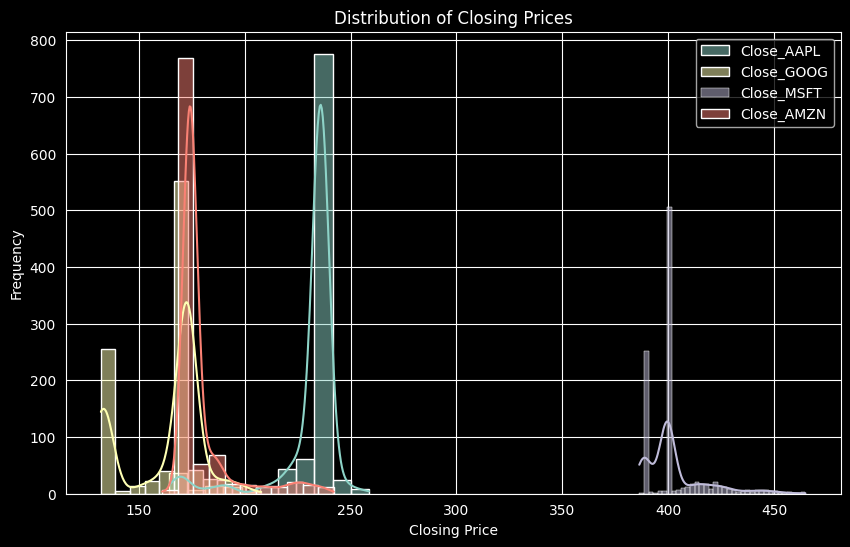

In [ ]:
plt.figure(figsize=(10, 6))
for stock in stocks:
    sns.histplot(df[stock], label=stock, kde=True, alpha=0.5)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

AAPL, GOOG, and AMZN: Show a unimodal distribution, meaning they have a single peak. The KDE curves are relatively symmetrical, suggesting a roughly normal distribution for these stocks within their respective price ranges.

MSFT: Also appears unimodal but is highly concentrated around the 400-425 range. This suggests less price volatility compared to the other stocks within the observed period.

Reshaping the Data for Visualization

This part of the code is focused on restructuring the stock market data to make it easier to create informative visualizations, specifically for comparing closing prices and trading volumes across different companies.



In [ ]:
# First, melt the data into a long format
df_melted = df.melt(id_vars=['company_name'],
                    value_vars=['Close_AAPL', 'Close_GOOG', 'Close_MSFT','Close_AMZN'],
                    var_name='Stock',
                    value_name='Close')

df_melted['Stock'] = df_melted['Stock'].str.split('_').str[1]  # Clean up stock names

# Similarly, for Volume
df_melted_vol = df.melt(id_vars=['company_name'],
                        value_vars=['Volume_AAPL', 'Volume_GOOG', 'Volume_MSFT','Volume_AMZN'],
                        var_name='Stock',
                        value_name='Volume')

df_melted_vol['Stock'] = df_melted_vol['Stock'].str.split('_').str[1]  # Clean up stock names

# Box Plot for Closing Prices

This code creates plots that shows the distribution of closing prices and volume for each stock (Apple, Google, Microsoft, Amazon), grouped by company. The boxes in the plot represent the interquartile range (IQR) of the data, the line inside the box is the median, and the whiskers extend to the minimum and maximum values, excluding outliers.

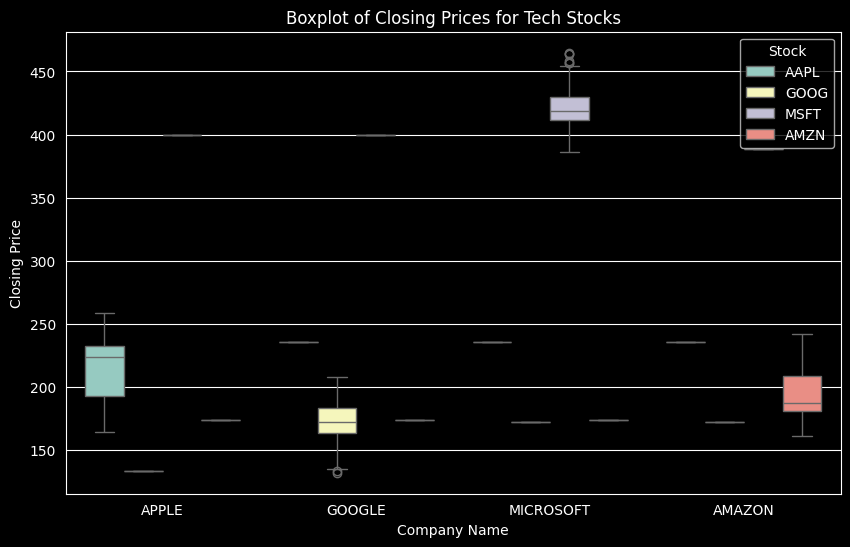

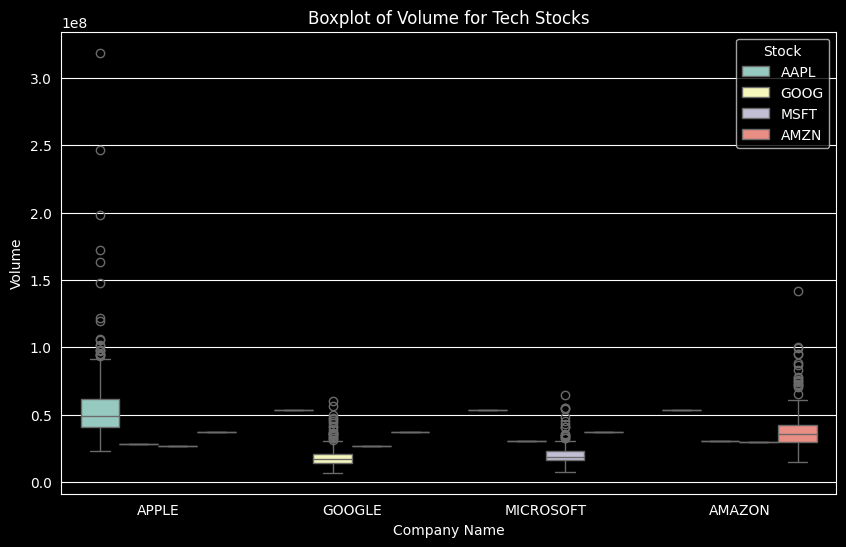

In [ ]:
# Plot Boxplot for Closing Prices
plt.figure(figsize=(10, 6))
sns.boxplot(x='company_name', y='Close', hue='Stock', data=df_melted)
plt.title('Boxplot of Closing Prices for Tech Stocks')
plt.xlabel('Company Name')
plt.ylabel('Closing Price')
plt.show()

# Plot Boxplot for Volume
plt.figure(figsize=(10, 6))
sns.boxplot(x='company_name', y='Volume', hue='Stock', data=df_melted_vol)
plt.title('Boxplot of Volume for Tech Stocks')
plt.xlabel('Company Name')
plt.ylabel('Volume')
plt.show()

Key Insights:

Price Level Comparison: Microsoft stands out with significantly higher closing prices, while Google has the lowest. Apple and Amazon have moderately ranged closing prices.

Price Volatility: Apple's wider IQR suggests a greater range and potentially higher volatility in its closing prices compared to the other stocks.

Price Stability: Microsoft, Google, and Amazon exhibit narrower IQRs, suggesting more stable closing prices within their respective ranges.

Trading Activity: Apple consistently experiences the highest trading activity, while Google and Microsoft have the lowest. Amazon falls in between.

Volatility of Volume: Apple's wider IQR and numerous outliers suggest higher volatility in its trading volume. Google, Microsoft, and Amazon exhibit more stable trading volumes.

Market Interest: The high volume in Apple could indicate higher market interest or liquidity compared to the other stocks.

# 3.2 Data Visualization

# Closing Price
The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time. This code snippet creates a 2x2 grid of plots, and in each plot, it displays the closing price (or adjusted closing price) of one of the stocks in tech_list over time.

<Figure size 1500x1000 with 0 Axes>

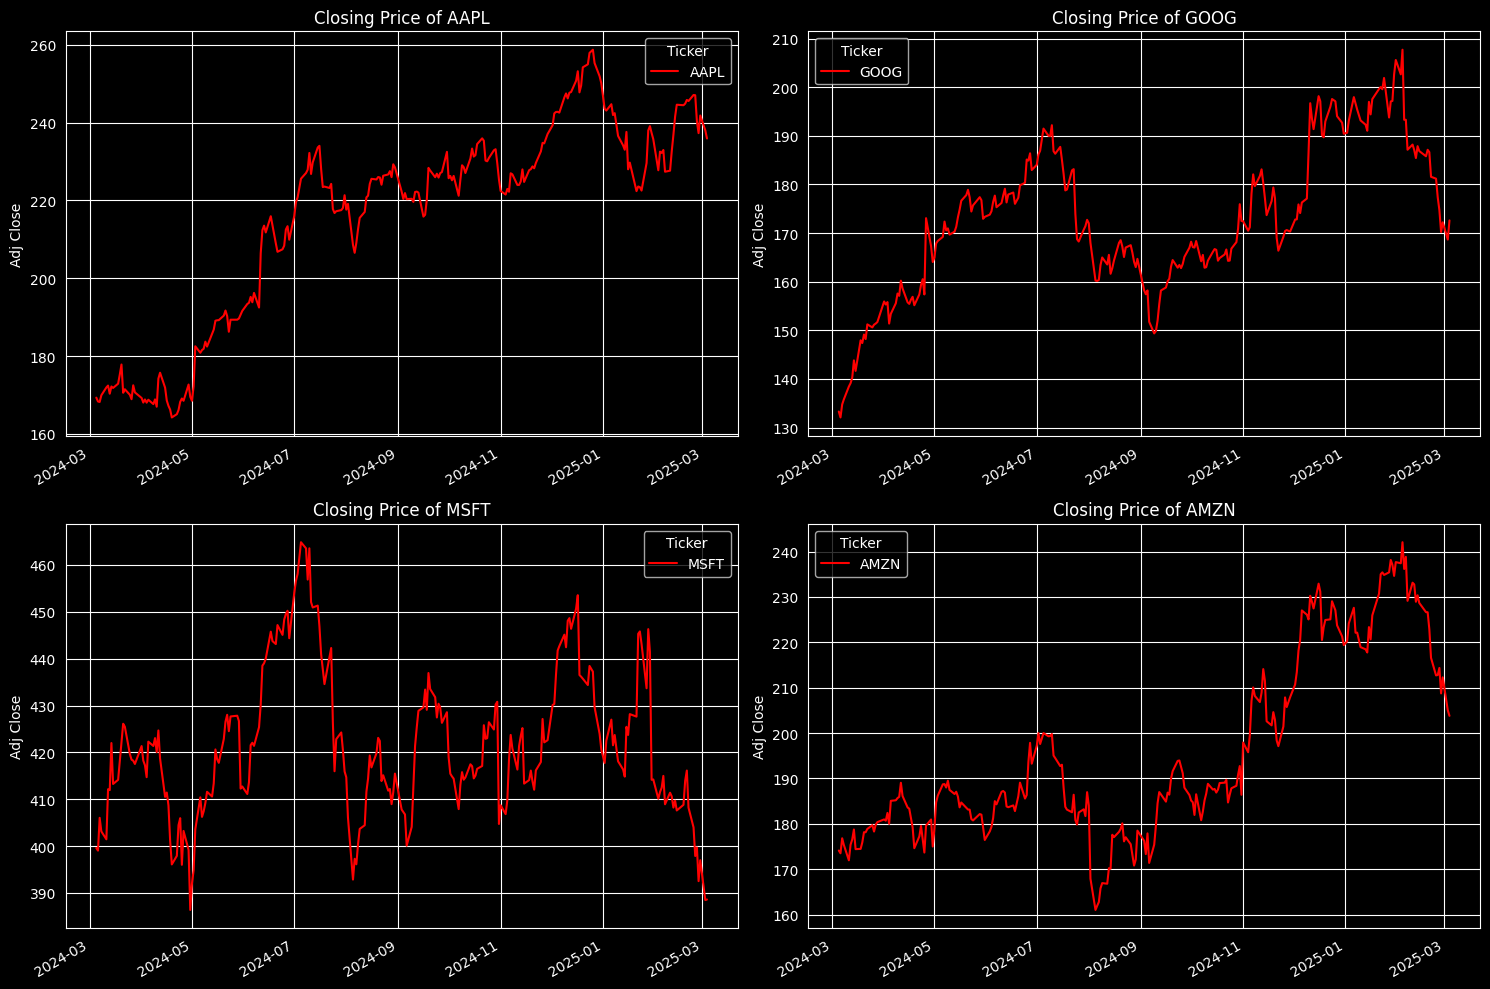

In [ ]:
plt.figure(figsize=(15, 10))
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2 rows, 2 columns
fig.subplots_adjust(hspace=0.3)  # Adjust spacing between plots

for i, (company, ax) in enumerate(zip(company_list, axes.flatten())):
    # Check if 'Adj Close' exists, else use 'Close'
    if 'Adj Close' in company.columns:
        company['Adj Close'].plot(ax=ax, color='red')
    else:
        company['Close'].plot(ax=ax, color='red')

    ax.set_ylabel('Adj Close')
    ax.set_xlabel(None)
    ax.set_title(f"Closing Price of {tech_list[i]}")

plt.tight_layout()
plt.show()

Comparative Analysis:

Growth Patterns: All four stocks show an overall upward trend during the observed period, indicating positive performance in the tech sector.

Volatility Differences: MSFT exhibits the highest volatility, followed by AAPL, AMZN, and then GOOG with the least volatility.

Price Level Differences: MSFT has a significantly higher price level compared to the other three stocks.

Recent Trends: AAPL and MSFT show a recent decline towards March 2025, while GOOG and AMZN maintain a more consistent upward trajectory.

# Volume of Sales
Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day. For instance, the stock trading volume would refer to the number of shares of security traded between its daily open and close. Trading volume, and changes to volume over the course of time, are important inputs for technical traders. This code takes stock data for multiple companies, creates a grid of plots, and then displays the sales volume for each company in a separate subplot, making it easier to visually compare their trading activity.

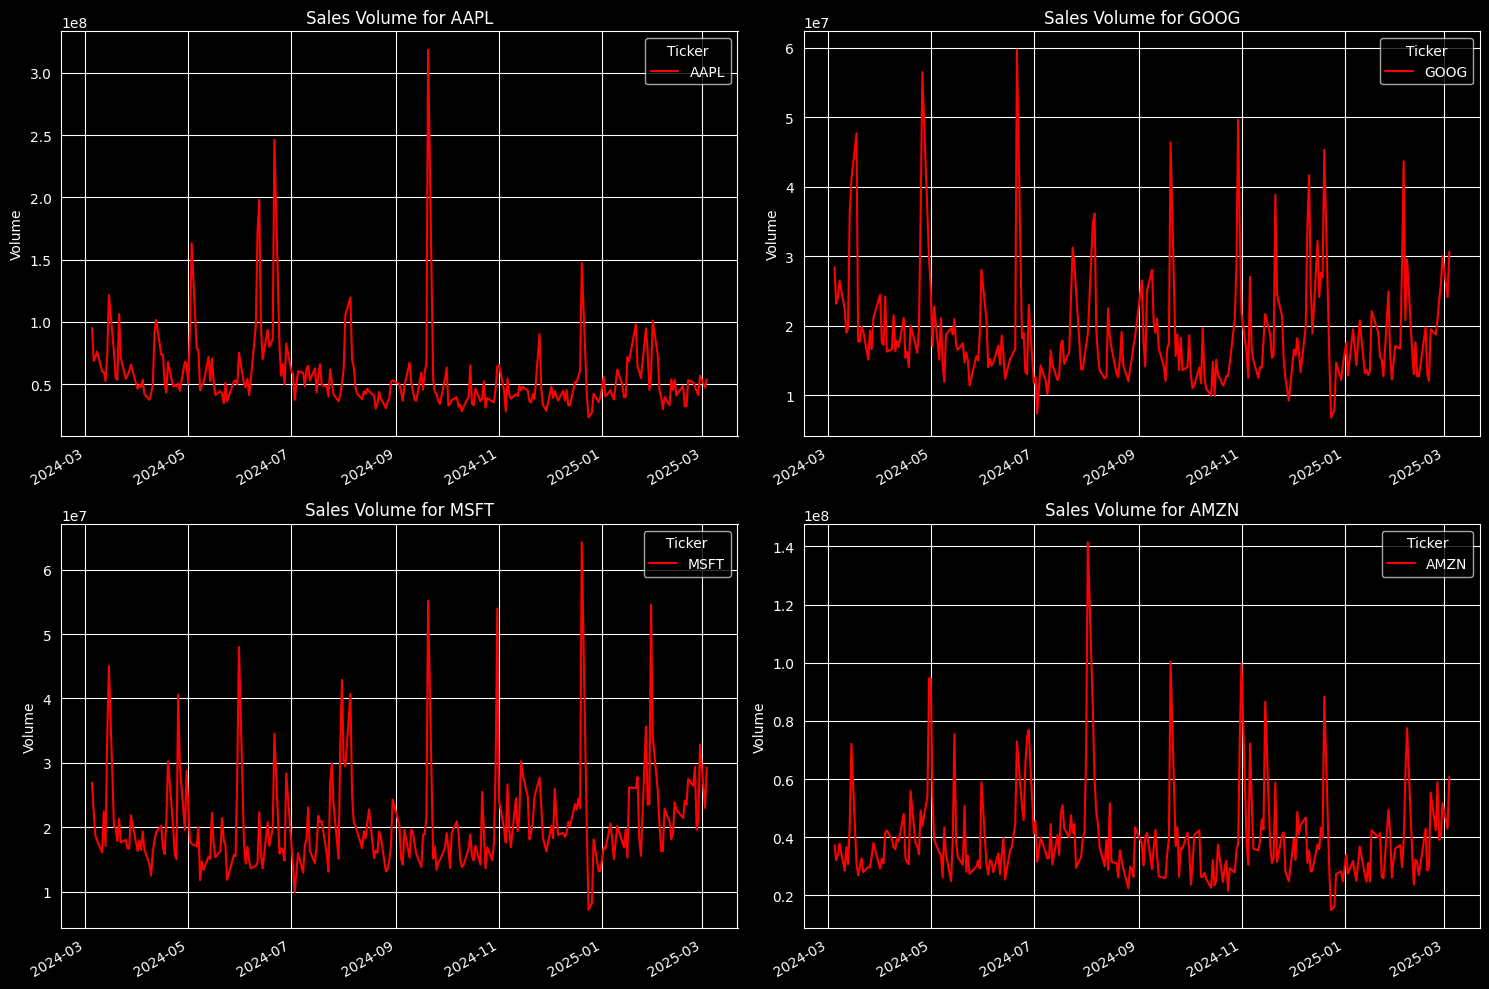

In [ ]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)  # Adjust vertical spacing between plots

# Loop through each company and corresponding subplot
for i, (company, ax) in enumerate(zip(company_list, axes.flatten())):
    company['Volume'].plot(ax=ax, color='red')
    ax.set_ylabel('Volume')
    ax.set_xlabel(None)
    ax.set_title(f"Sales Volume for {tech_list[i]}")

plt.tight_layout()
plt.show()

Comparative Analysis:

Volume Scale Differences: Note the significant differences in the scales of the y-axis. AAPL and AMZN have volume in the hundreds of millions, while GOOG and MSFT have volume in the tens of millions.

Spike Frequency: AAPL and AMZN exhibit the most frequent and dramatic spikes in trading volume, indicating periods of high trading activity.

Volatility Differences: AAPL and AMZN show higher volatility in trading volume compared to GOOG and MSFT.

Now that we've seen the visualizations for the closing price and the volume traded each day, let's go ahead and caculate the moving average for the stock.

# 2. What was the moving average of the various stocks?
The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

ma_day = [10, 20, 50]: This line defines a list ma_day containing the window sizes for calculating moving averages (10 days, 20 days, and 50 days).

The code then uses two nested loops:
The outer loop iterates through each moving average window size (ma) in the ma_day list.
The inner loop iterates through each company in the company_list.

Inside the loops:
close_col = 'Close': Specifies that we'll use the 'Close' column for calculations.

column_name = f"MA for {ma} days": Creates a column name for the moving average (e.g., "MA for 10 days").
company[column_name] = company[close_col].rolling(ma).mean(): This is the core of the calculation.

It uses the rolling() method with the window size (ma) and mean() to calculate the moving average.

The result is then stored in a new column within the company DataFrame. In essence, this code calculates and visualizes moving averages to help identify trends in stock prices over different time periods.

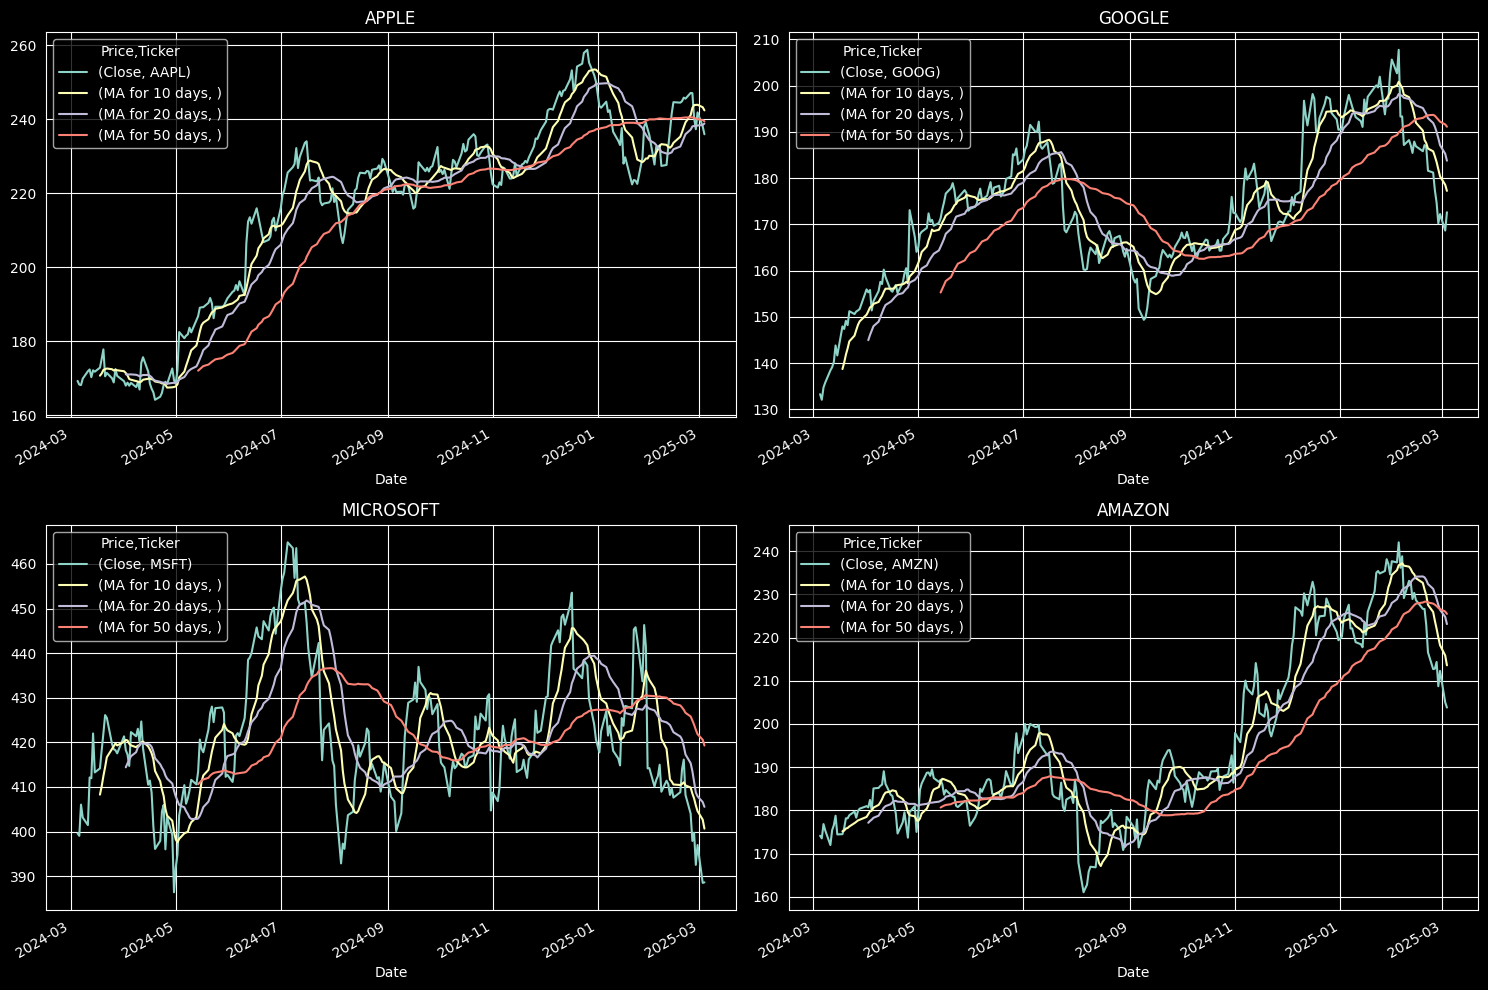

In [ ]:
#moving averages plotted
ma_day = [10, 20, 50]
for ma in ma_day:
    for company in company_list:
        # Check if 'Adj Close' column exists, if not, try 'Close'
        # The column name is 'Close', not 'Adj Close'
        close_col = 'Close'
        column_name = f"MA for {ma} days"
        company[column_name] = company[close_col].rolling(ma).mean()
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
# Use 'Close' instead of 'Adj Close' for plotting
AAPL[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')
GOOG[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')
MSFT[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')
AMZN[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')
fig.tight_layout()

Key Insights from Moving Averages:

Trend Identification: The 50-day MA provides a longer-term trend indication, while the 10-day and 20-day MAs reflect shorter-term trends.

Momentum Changes: Crossovers between the MAs can signal changes in momentum. For example, when the 10-day MA crosses above the 50-day MA, it can indicate a bullish signal.



# 3. What was the daily return of the stock on average?
Now that we've done some baseline analysis, let's go ahead and dive a little deeper. We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value. Let's go ahead and use pandas to retrieve the daily returns for the Apple stock.

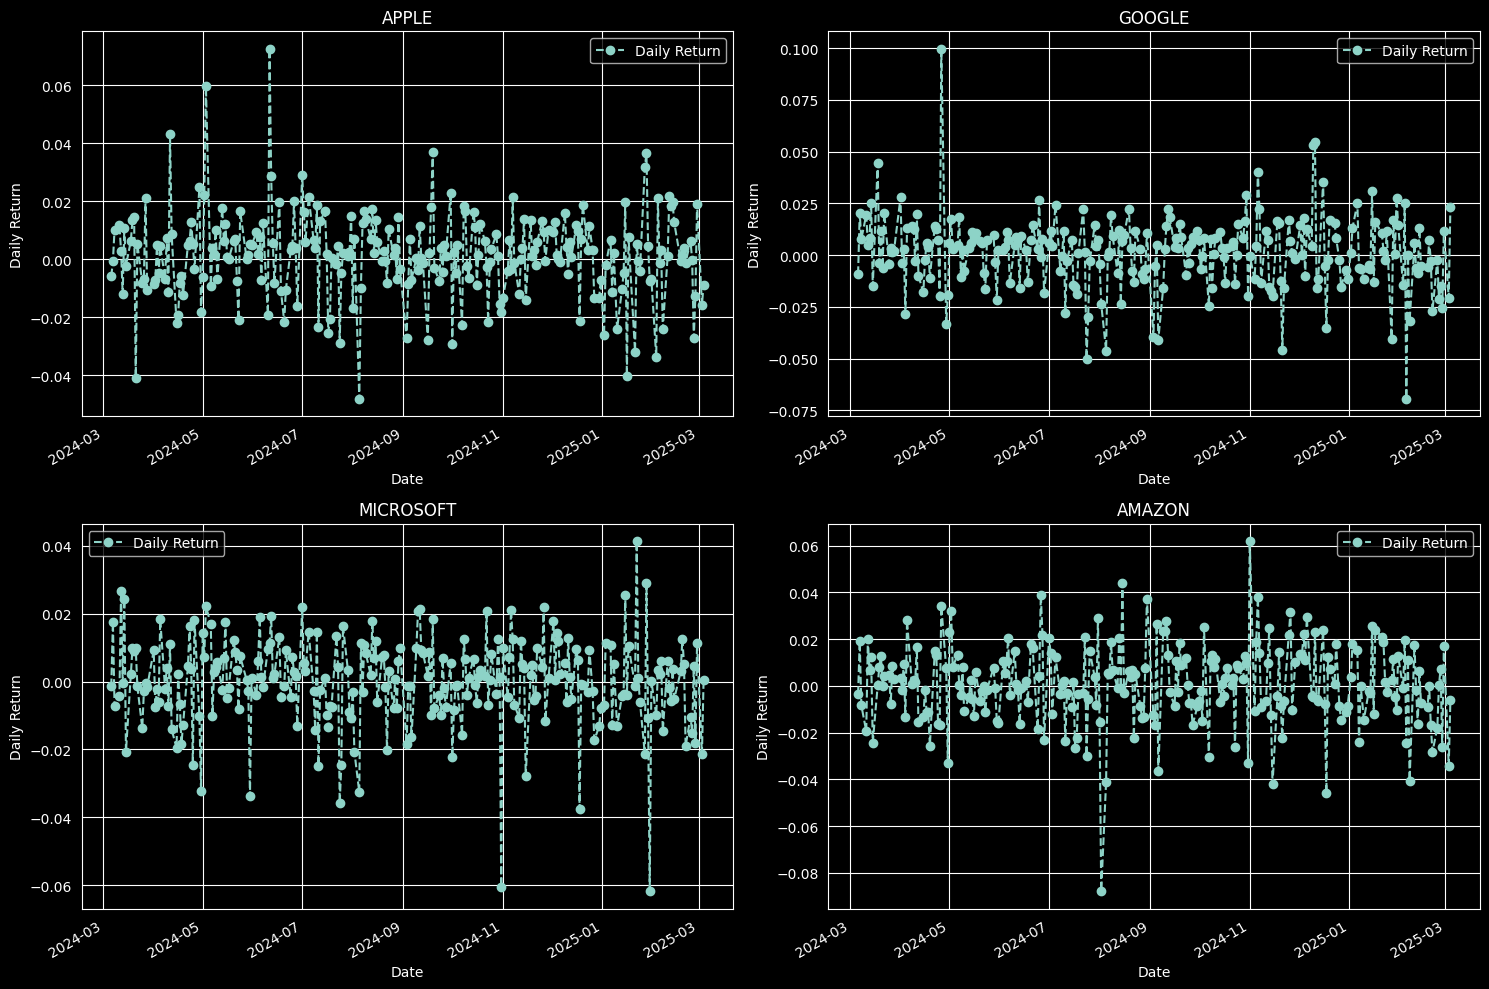

In [ ]:
# Ensure we use 'Close' if 'Adj Close' is missing
for company in company_list:
    if 'Adj Close' in company.columns:
        company['Daily Return'] = company['Adj Close'].pct_change()
    else:
        company['Daily Return'] = company['Close'].pct_change()  # Use 'Close' if 'Adj Close' is missing

# Create subplots in a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)  # Adjust spacing between subplots

# Plot daily returns for each company
for ax, company, name in zip(axes.flatten(), company_list, ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]):
    company['Daily Return'].plot(ax=ax, legend=True, linestyle='--', marker='o')
    ax.set_title(name)
    ax.set_ylabel('Daily Return')

fig.tight_layout()
plt.show()

Comparative Analysis:

Volatility Differences: GOOG and AMZN exhibit higher volatility, with wider ranges of daily returns compared to AAPL and MSFT.

Spike Frequency: All four stocks show occasional spikes in daily returns, indicating periods of significant price changes.

Recent Performance: MSFT and AMZN both show a large negative return towards the end of the period, suggesting a potential downward trend.

Great, now let's get an overall look at the average daily return using a histogram. We'll use seaborn to create both a histogram and kde plot on the same figure.

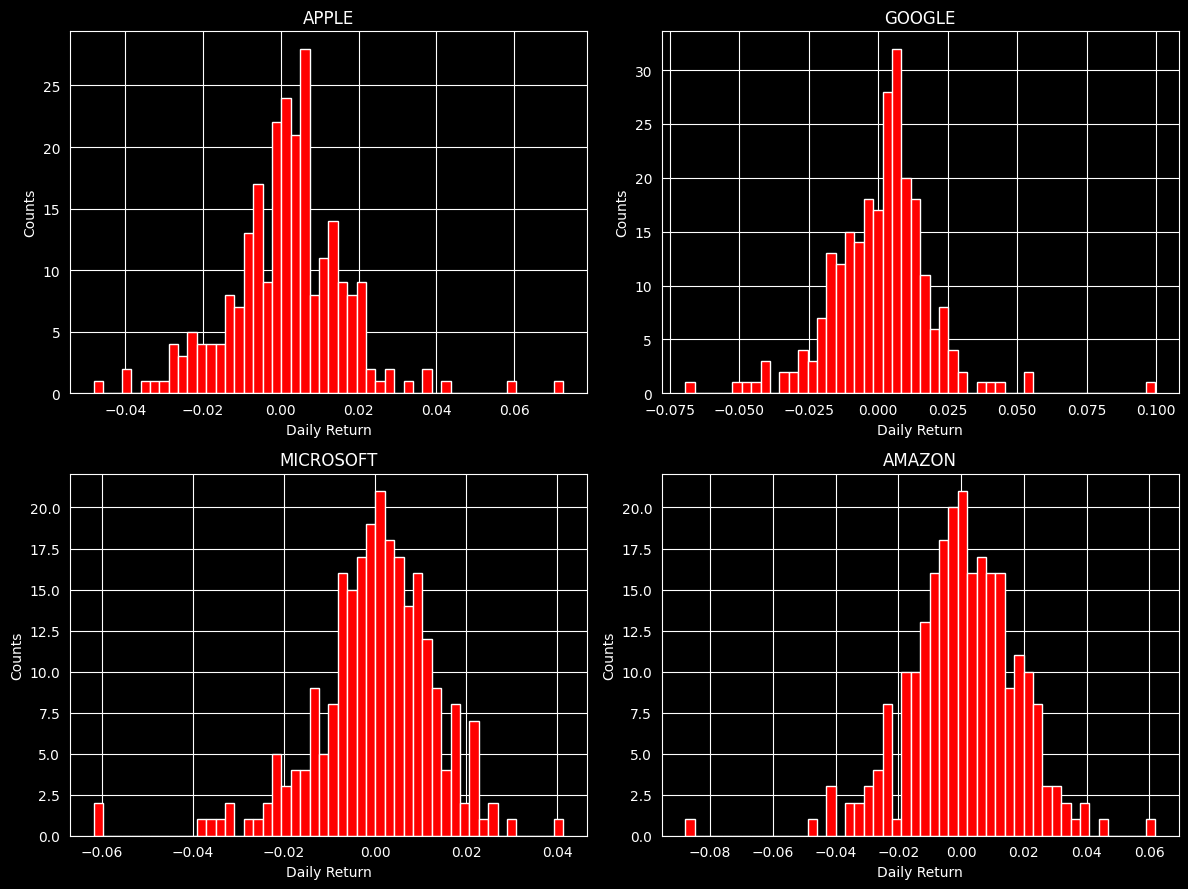

In [ ]:
plt.figure(figsize=(12, 9))
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50,color='red')
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')
plt.tight_layout()

Comparative Analysis:

Volatility Differences: GOOG and AMZN exhibit higher volatility, with wider ranges of daily returns compared to AAPL and MSFT.

Skewness: AAPL shows a slight positive skew, while MSFT shows a slight negative skew. GOOG and AMZN are relatively symmetrical.

Concentration: All four stocks show a concentration of daily returns around 0, indicating that small daily fluctuations are most common.

# 4. What was the correlation between different stocks closing prices?
Correlation is a statistic that measures the degree to which two variables move in relation to each other which has a value that must fall between -1.0 and +1.0. Correlation measures association, but doesn’t show if x causes y or vice versa — or if the association is caused by a third factor[1].

Now what if we wanted to analyze the returns of all the stocks in our list? Let's go ahead and build a DataFrame with all the ['Close'] columns for each of the stocks dataframes.

In [ ]:
# Define stock symbols and the date range
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
start = '2024-03-01'
end = '2025-03-01'

# Download stock data using yfinance
closing_df = yf.download(tech_list, start=start, end=end)['Close']

# Calculate daily returns for each stock
tech_rets = closing_df.pct_change()

# Display the first few rows of the returns DataFrame
print(tech_rets.head())

# Correlation between the returns
correlation_matrix = tech_rets.corr()
print(correlation_matrix)


[*********************100%***********************]  4 of 4 completed

Ticker          AAPL      AMZN      GOOG      MSFT
Date                                              
2024-03-01       NaN       NaN       NaN       NaN
2024-03-04 -0.025381 -0.003591 -0.028100 -0.001396
2024-03-05 -0.028441 -0.019484 -0.003130 -0.029572
2024-03-06 -0.005878 -0.003503 -0.009119 -0.001391
2024-03-07 -0.000710  0.019077  0.020217  0.017533
Ticker      AAPL      AMZN      GOOG      MSFT
Ticker                                        
AAPL    1.000000  0.332091  0.315638  0.442272
AMZN    0.332091  1.000000  0.564381  0.650643
GOOG    0.315638  0.564381  1.000000  0.499301
MSFT    0.442272  0.650643  0.499301  1.000000


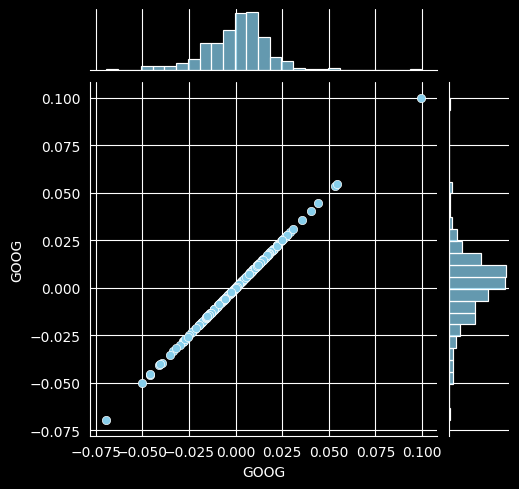

In [ ]:
# Now we can compare the daily percentage return of two stocks to check how correlated. First let's see a stock compared to itself.
# Comparing Google to itself should show a perfectly linear relationship
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='skyblue',height=5)

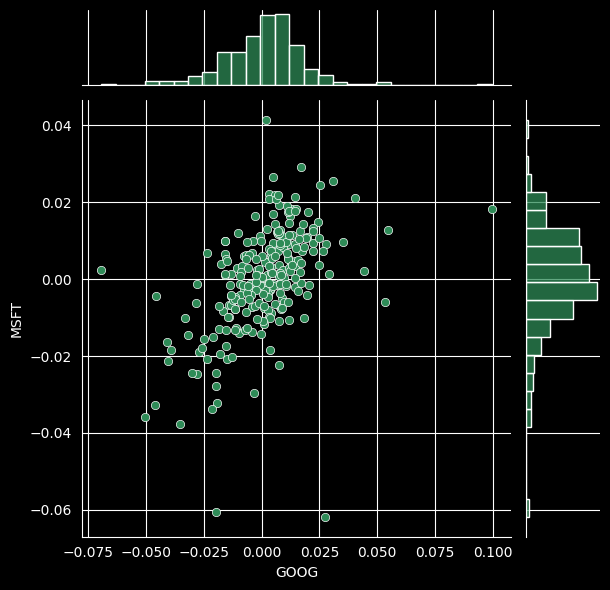

In [ ]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter', color='seagreen')

So now we can see that if two stocks are perfectly (and positivley) correlated with each other a linear relationship bewteen its daily return values should occur.

Seaborn and pandas make it very easy to repeat this comparison analysis for every possible combination of stocks in our technology stock ticker list. We can use sns.pairplot() to automatically create this plot

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


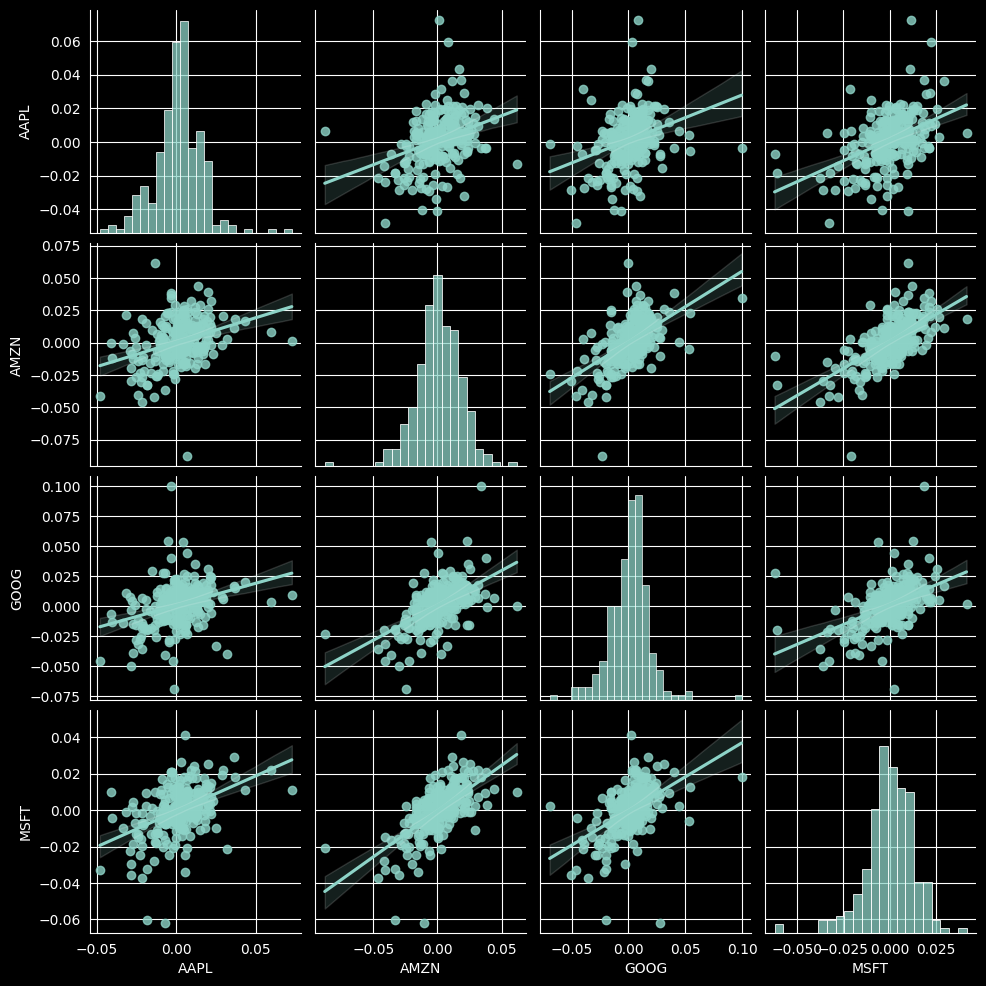

In [ ]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis
# of all the comparisons
sns.pairplot(tech_rets, kind='reg', palette='green')

Key Insights:

Positive Correlations: All stock pairs exhibit positive correlations, indicating that their daily returns tend to move in the same direction. This suggests that these stocks are influenced by similar market factors or trends.

Strength of Correlations: The strength of the correlations varies. Some pairs show stronger correlations (tighter scatter around the regression line) than others.

Volatility Differences: The histograms on the diagonal highlight the differences in volatility among the stocks, with GOOG and AMZN showing higher volatility compared to AAPL and MSFT.

Linear Relationships: The regression lines suggest that the relationships between the daily returns are approximately linear.

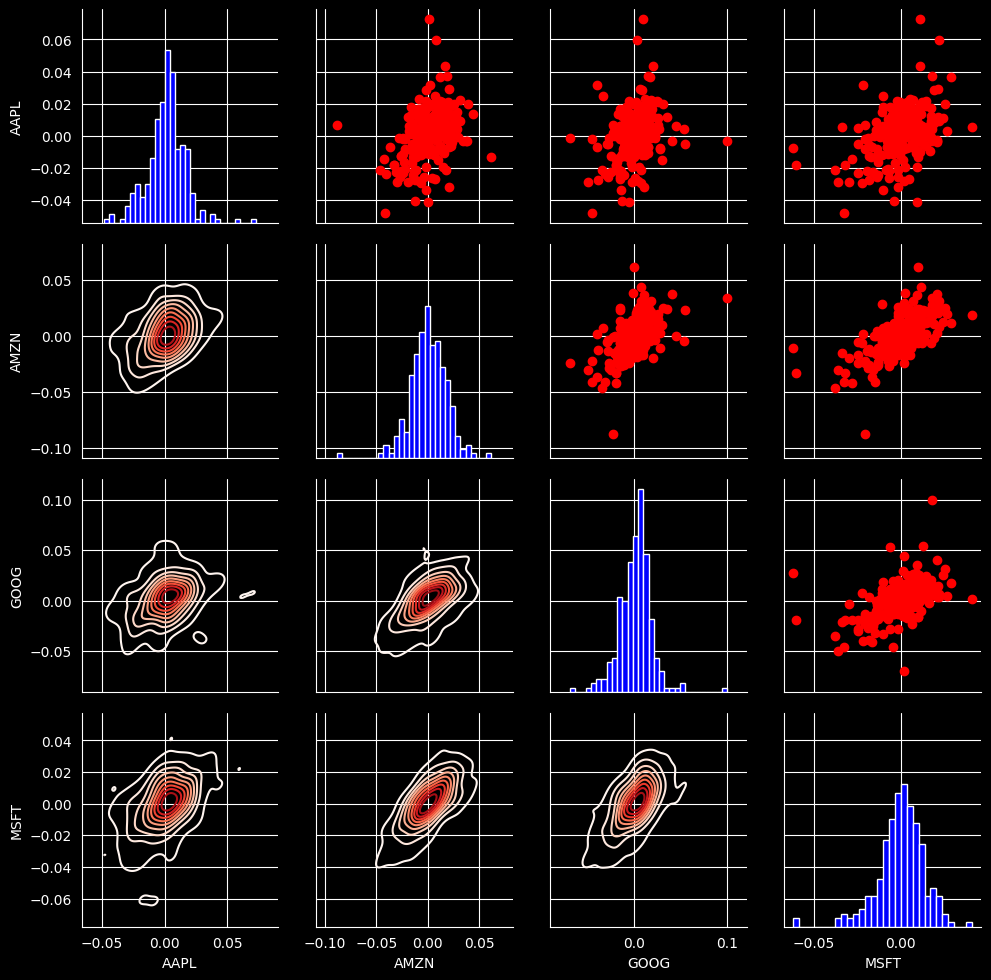

In [ ]:
# Set up our figure by naming it returns_fig, call PairGrid on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())
# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='red')
# We can also define the lower triangle in the figure, including the plot type (kde)
# or the color map (Reds)
return_fig.map_lower(sns.kdeplot, cmap='Reds')
# Finally, we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30, color='blue')
# Show the plot
plt.show()

Key Insights:

Positive Correlations: All stock pairs exhibit positive correlations, indicating that their daily returns tend to move in the same direction. This confirms the previous analysis.

Strength of Correlations: The density plots in the lower triangle provide a visual indication of the strength of the correlations. Tighter, more elliptical contours suggest stronger correlations.

Volatility Differences: The histograms on the diagonal highlight the differences in volatility among the stocks, with GOOG and AMZN showing higher volatility compared to AAPL and MSFT.

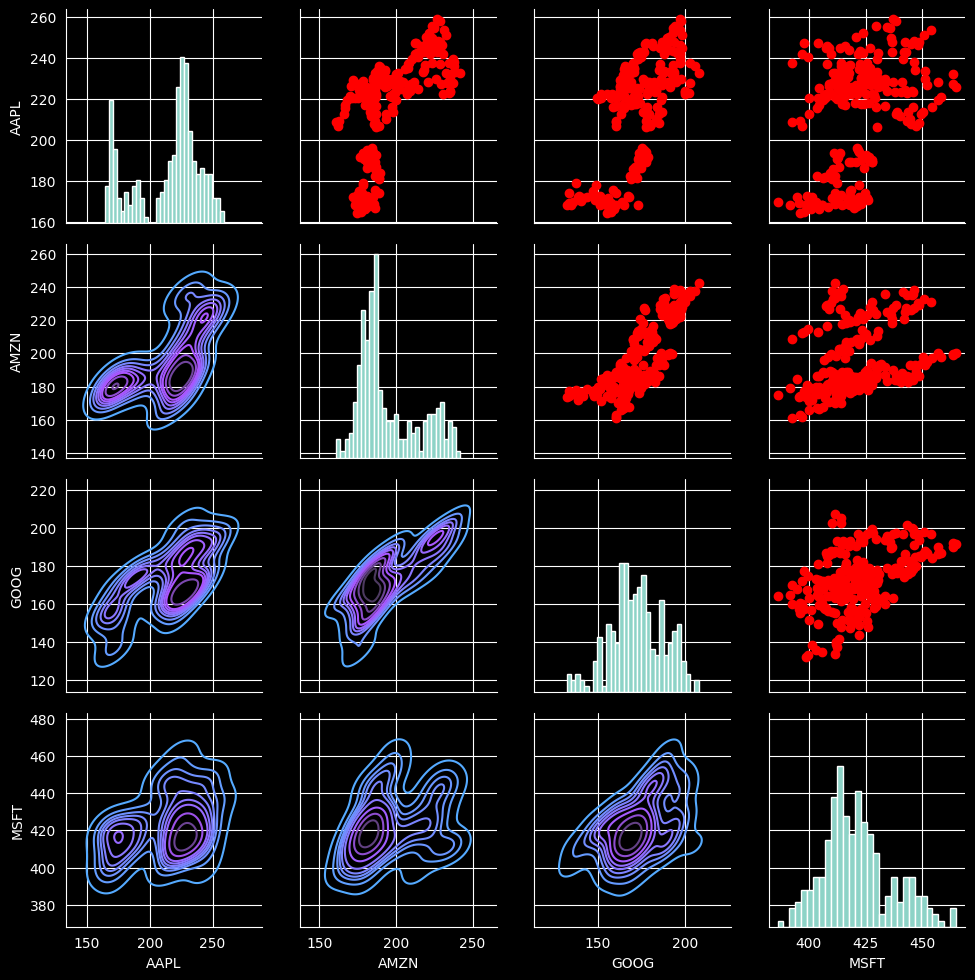

In [ ]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='red')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

Key Insights:

Price Level Differences: MSFT has a significantly higher price range compared to the other three stocks, as seen in the histograms and scatter plots.

Strong Correlations: AAPL, AMZN, and GOOG show strong positive correlations with each other, suggesting that their prices tend to move together.

Weak Correlations with MSFT: MSFT shows weak positive correlations with the other three stocks, indicating that its price movements are less related to them.

Bimodal Distributions: AAPL, AMZN, and GOOG exhibit bimodal distributions, suggesting that their prices have fluctuated between two distinct ranges.

Finally, we could also do a correlation plot, to get actual numerical values for the correlation between the stocks' daily return values. By comparing the closing prices, we see an interesting relationship between Microsoft and Apple.

Text(0.5, 1.0, 'Correlation of stock closing price')

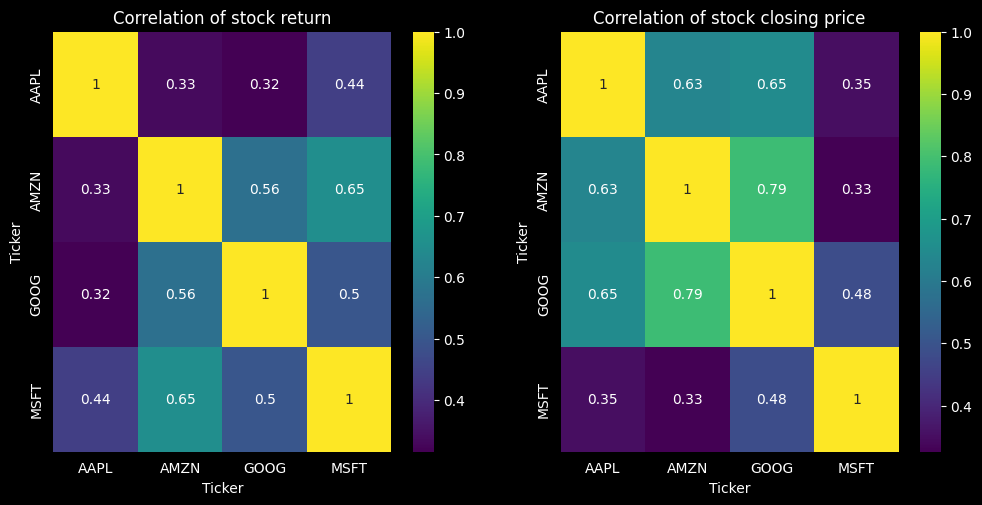

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='viridis')
plt.title('Correlation of stock return')
plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='viridis')
plt.title('Correlation of stock closing price')

AAPL and AMZN showed moderate volatility and strong positive correlations with each other. GOOG exhibited the least volatility and a consistent upward trend.
MSFT stood out with its high volatility, negative correlations with AAPL and AMZN in closing prices, and a recent downward trend.

# 5. How much value do we put at risk by investing in a particular stock?
There are many ways we can quantify risk, one of the most basic ways using the information we've gathered on daily percentage returns is by comparing the expected return with the standard deviation of the daily returns.

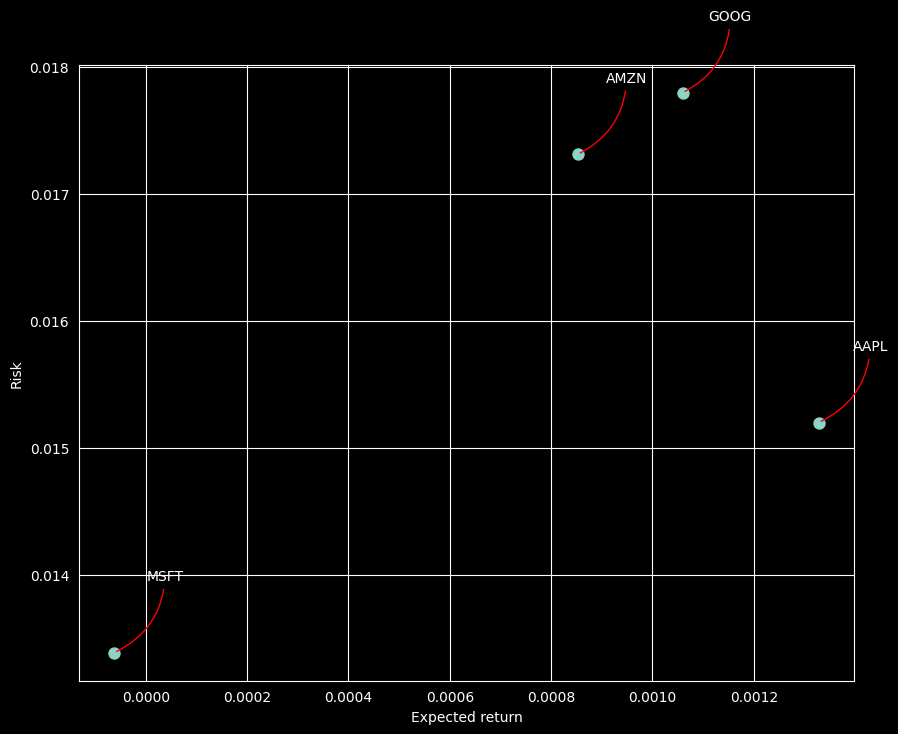

In [ ]:
rets = tech_rets.dropna()
area = np.pi * 20
plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='red', connectionstyle='arc3,rad=-0.3'))

Key Insights:

Risk-Return Tradeoff: The chart illustrates the classic risk-return tradeoff. Stocks with higher expected returns tend to have higher risks, and vice versa.

GOOG and AMZN: These stocks have the highest expected returns but also the highest risks, indicating a higher potential reward but also higher potential losses.

MSFT: This stock has the lowest expected return but also the lowest risk, indicating a lower potential reward but also lower potential losses.

AAPL: This stock falls in the middle, offering a balance between risk and return.

Now lets predict the closing stock price of APPLE inc.

# 4.0 Predictive Analytics

# Predicting the closing price stock price of APPLE inc:

In [ ]:
# Get the stock quote for 'AAPL'
df = yf.download('AAPL', start='2012-01-01', end=datetime.now().strftime('%Y-%m-%d'))

# Show the data
print(df.head())

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2012-01-03  12.375391  12.413610  12.308283  12.320320  302220800
2012-01-04  12.441893  12.479210  12.316704  12.338371  260022000
2012-01-05  12.580028  12.595676  12.418725  12.487340  271269600
2012-01-06  12.711538  12.722071  12.615841  12.632392  318292800
2012-01-09  12.691373  12.872536  12.679937  12.804826  394024400


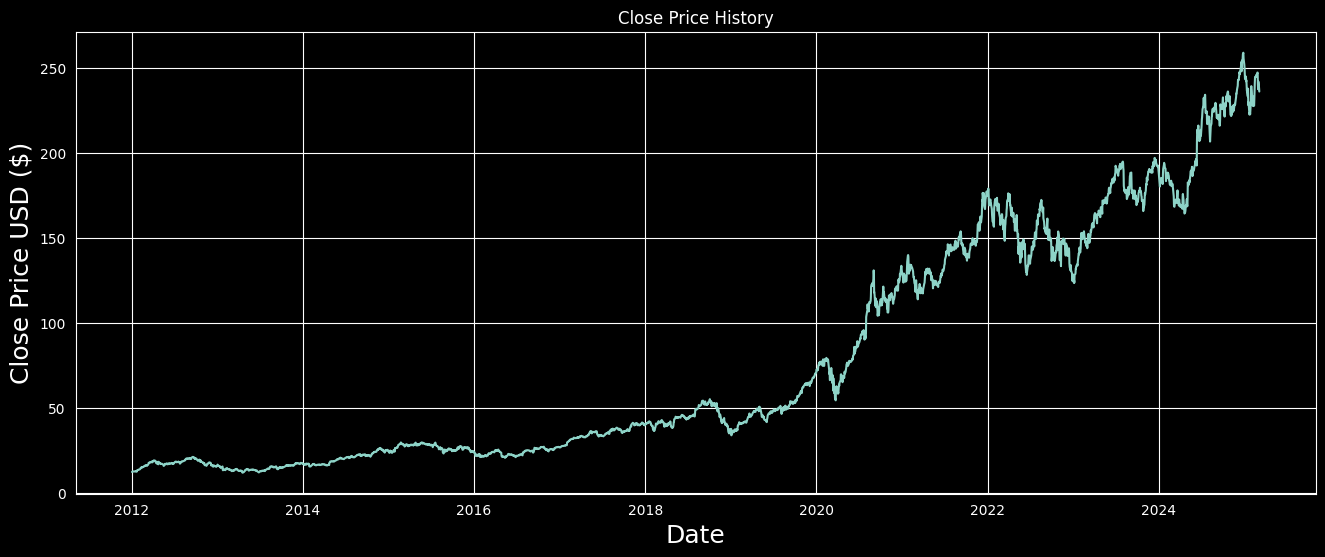

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

# Data Examination and Preparation

 This code segment prepares the stock data for machine learning by:

Examining the structure and content of the raw data.

Selecting the specific column needed (Apple's closing prices).

Converting the data into a format suitable for machine learning (NumPy array).

Determining the amount of data to use for training.

Scaling the data to improve model performance.

In [ ]:
print("DataFrame Columns:", df.columns)  # Check column names
print("DataFrame Head:\n", df.head())  # Check DataFrame content

# Access the 'Close' column using the MultiIndex tuple
data = df[('Close', 'AAPL')].to_frame() # to_frame() converts the series to a dataframe.

print("Filtered Data:\n", data) # Check the data that is being filtered.

# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95))
training_data_len
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

DataFrame Columns: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
DataFrame Head:
 Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2012-01-03  12.375391  12.413610  12.308283  12.320320  302220800
2012-01-04  12.441893  12.479210  12.316704  12.338371  260022000
2012-01-05  12.580028  12.595676  12.418725  12.487340  271269600
2012-01-06  12.711538  12.722071  12.615841  12.632392  318292800
2012-01-09  12.691373  12.872536  12.679937  12.804826  394024400
Filtered Data:
                  Close
                  AAPL
Date                  
2012-01-03   12.375391
2012-01-04   12.441893
2012-01-05   12.580028
2012-01-06   12.711538
2012-01-09   12.691373
...                ...
2025-02-26  24

array([[0.00182111],
       [0.00209055],
       [0.00265023],
       ...,
       [0.93154436],
       [0.91610737],
       [0.90759876]])

This code snippet prepares a time series dataset with a sliding window approach, where the model learns to predict the target value based on past values in the sequence

In [ ]:
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00182111, 0.00209055, 0.00265023, 0.00318308, 0.00310137,
       0.00328548, 0.00320134, 0.00305992, 0.00286726, 0.0034635 ,
       0.00400123, 0.0038354 , 0.00292701, 0.00379393, 0.00294042,
       0.0061411 , 0.00589358, 0.00621671, 0.00691536, 0.00733846,
       0.0073031 , 0.00717263, 0.00772865, 0.00825172, 0.0088443 ,
       0.00980147, 0.0118121 , 0.01184257, 0.01296188, 0.01379833,
       0.01236076, 0.01291434, 0.01290334, 0.01445553, 0.01423483,
       0.01464331, 0.01537732, 0.01578578, 0.01696243, 0.01781959,
       0.0180671 , 0.01815369, 0.0166881 , 0.0163345 , 0.01638691,
       0.01776474, 0.0181525 , 0.01898526, 0.02094831, 0.02356739,
       0.02307725, 0.02307846, 0.02497203, 0.02556462, 0.02514271,
       0.02475744, 0.02435628, 0.02568898, 0.02660345, 0.02698635])]
[0.02604014839307363]

[array([0.00182111, 0.00209055, 0.00265023, 0.00318308, 0.00310137,
       0.00328548, 0.00320134, 0.00305992, 0.00286726, 0.0034635 ,
       0.00400123, 0.0038354 , 0.00

# Building and training the LSTM Model

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 158s 50ms/step - loss: 0.0025
Epoch 2/5
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 155s 50ms/step - loss: 4.8032e-04
Epoch 3/5
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 202s 50ms/step - loss: 3.3598e-04
Epoch 4/5
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 154s 50ms/step - loss: 2.6610e-04
Epoch 5/5
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 155s 50ms/step - loss: 1.6566e-04


# Preparing the Test Data, Making Predictions and Evaluating the Model



In [ ]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
# Convert the data to a numpy array
x_test = np.array(x_test)
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


3.9709668616509872

# Plotting the Predictions
This code snippet is all about visualizing the performance of the stock price prediction model. It takes the predicted stock prices and compares them to the actual prices to see how well the model did.

<ipython-input-120-0cdd5e68a3a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


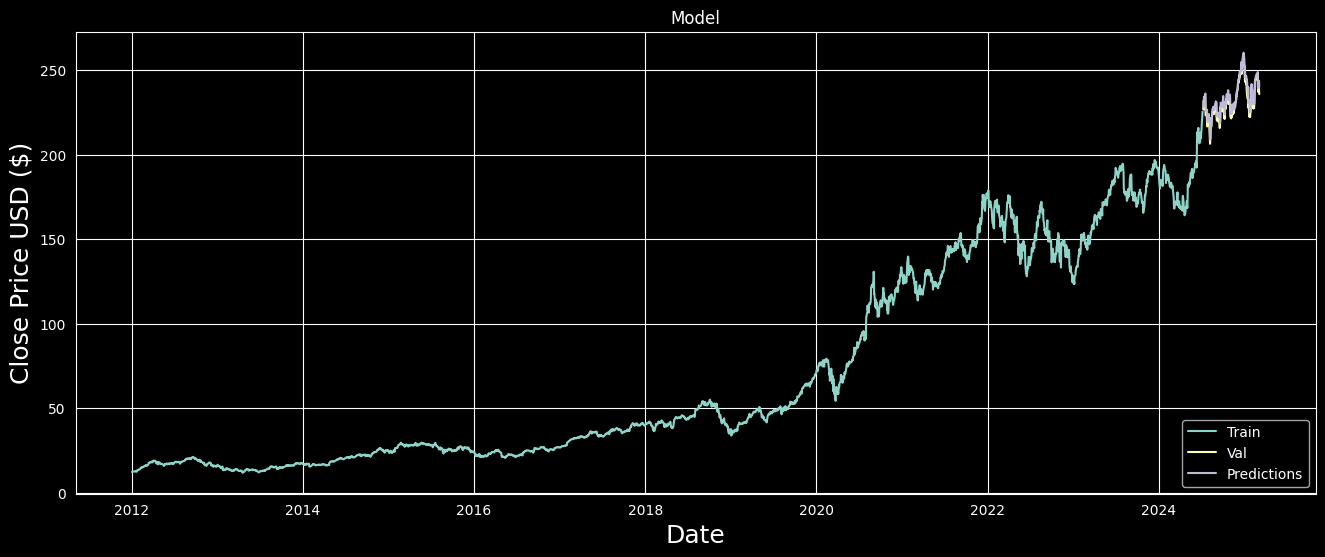

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

The LSTM model demonstrated its ability to capture the general upward trend of the stock price, which is consistent with its strength in learning long-term dependencies in time series data. However, the deviations observed in the validation period might be due to overfitting, a common challenge with complex models like LSTMs.

In [ ]:
# Show the valid and predicted prices
valid

,Close,Predictions
,AAPL,
Date,,
2024-07-08,227.056885,228.044769
2024-07-09,227.913986,229.532883
2024-07-10,232.199585,230.305481
2024-07-11,226.807724,234.390625
2024-07-12,229.767761,229.216324
...,...,...
2025-02-26,240.360001,248.893127
2025-02-27,237.300003,242.407852


In [ ]:
#save LSTM model

model.save('model.h5')


# XGBoost Model for price prediction

# Data Preparation

In [ ]:
print("DataFrame Columns:", df.columns)  # Check column names
print("DataFrame Head:\n", df.head())  # Check DataFrame content

DataFrame Columns: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
DataFrame Head:
 Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2012-01-03  12.375391  12.413610  12.308283  12.320320  302220800
2012-01-04  12.441893  12.479210  12.316704  12.338371  260022000
2012-01-05  12.580028  12.595676  12.418725  12.487340  271269600
2012-01-06  12.711538  12.722071  12.615841  12.632392  318292800
2012-01-09  12.691373  12.872536  12.679937  12.804826  394024400


Select and Filter Data

data = df[('Close', 'AAPL')].to_frame(): This line is selecting only the closing price data for Apple (AAPL) and converting it into a new DataFrame called data. .to_frame() is used to ensure the data is in a DataFrame format.

In [ ]:
# Access the 'Close' column using the MultiIndex tuple
data = df[('Close', 'AAPL')].to_frame() # to_frame() converts the series to a dataframe.

print("Filtered Data:\n", data) # Check the data that is being filtered.

# Convert the dataframe to a numpy array
dataset = data.values

Filtered Data:
                  Close
                  AAPL
Date                  
2012-01-03   12.375391
2012-01-04   12.441893
2012-01-05   12.580028
2012-01-06   12.711538
2012-01-09   12.691373
...                ...
2025-02-26  240.360001
2025-02-27  237.300003
2025-02-28  241.839996
2025-03-03  238.029999
2025-03-04  235.929993

[3311 rows x 1 columns]


Split Data into Training and Testing Sets

training_data_len = int(np.ceil(len(dataset) * .8)): This line calculates the number of data points to use for training the model. It takes 80% of the total data and rounds it up to the nearest integer using np.ceil.

In [ ]:
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .8))
print("Training data length:", training_data_len)

Training data length: 2649


Scale the Data

scaler = MinMaxScaler(feature_range=(0, 1)): This line creates a MinMaxScaler object from the sklearn.preprocessing module. This scaler will be used to transform the data to a specific range (0 to 1 in this case).

In [ ]:
# Scale the data to range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
print("Scaled Data Sample:\n", scaled_data[:5])  # Check a sample of scaled data

Scaled Data Sample:
 [[0.00182111]
 [0.00209055]
 [0.00265023]
 [0.00318308]
 [0.00310137]]


# Creating the Multi-step Dataset for XGBoost

create_multistep_dataset function: This function prepares the data for multi-step forecasting. It creates two lists, X (features) and y (labels). For each data point, it takes the previous time_step (60 in this case) values as features and the next n_steps (5 in this case) values as labels. Essentially, it's using the past 60 days of data to predict the stock price for the next 5 days.

Creating X and y: The function is called to create the feature and label sets (X and y) using the scaled stock data.

Reshaping X: The feature set X is reshaped to be compatible with XGBoost's input requirements.

In [ ]:
# Prepare the data for XGBoost - We need to create features and labels for multi-step forecasting
def create_multistep_dataset(data, time_step=60, n_steps=5):
    X = []
    y = []
    for i in range(time_step, len(data) - n_steps + 1):
        X.append(data[i - time_step:i, 0])  # Use the last `time_step` values for prediction
        y.append(data[i:i + n_steps, 0])  # Predict the next `n_steps` values (e.g., 5 days)
    return np.array(X), np.array(y)

# Create the dataset with a time step of 60 (for 60 days of history) and predicting 5 days ahead
n_steps = 5  # Predict 5 days ahead
X, y = create_multistep_dataset(scaled_data, time_step=60, n_steps=n_steps)

# Reshape X to be 3D (samples, time_step, features) for XGBoost input
X = X.reshape(X.shape[0], X.shape[1])

# Training and Evaluating the XGBoost Model

Splitting data: The data is split into training and testing sets using train_test_split from sklearn.model_selection. This is done to evaluate the model's performance on unseen data.

Creating and training the model: An XGBoost regressor model (XGBmodel) is created and trained using the training data (X_train, y_train).

Making predictions: The trained model is used to make predictions on the test data (X_test).

Evaluating the model: The Root Mean Squared Error (RMSE) is calculated to measure the accuracy of the predictions. A lower RMSE indicates better performance.

Inverse scaling: The predictions and true values are inverse transformed using the scaler to get back to the original scale of the stock prices.

In [ ]:
# Split the data into training and testing sets (95% train, 5% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)
# Train an XGBoost model
XGBmodel = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, objective='reg:squarederror')
# Fit the model on the training data
XGBmodel.fit(X_train, y_train)
# Make predictions on the test set
predictions = XGBmodel.predict(X_test)
# Calculate the RMSE (Root Mean Squared Error) for model evaluation
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: ", rmse)
# Inverse transform the scaled predictions to get back to original scale
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, n_steps))  # Reshape to match n_steps
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, n_steps))
# Print some sample predictions and true values
print("Predicted values (next 5 days):\n", predictions_rescaled[:5])
print("True values (next 5 days):\n", y_test_rescaled[:5])

RMSE:  0.14449860833270142
Predicted values (next 5 days):
 [[149.94284 149.24802 149.24905 149.08054 149.1732 ]
 [149.58534 149.49518 148.55586 150.75633 149.32057]
 [154.78151 156.71744 156.6937  153.89142 153.10345]
 [156.5493  157.69473 155.07695 154.89023 152.89511]
 [157.65805 156.45859 159.72293 160.7885  159.73563]]
True values (next 5 days):
 [[149.4019165  154.51661682 155.06852722 160.15368652 159.16819763]
 [154.51661682 155.06852722 160.15368652 159.16819763 157.68998718]
 [155.06852722 160.15368652 159.16819763 157.68998718 163.72123718]
 [160.15368652 159.16819763 157.68998718 163.72123718 163.40586853]
 [159.16819763 157.68998718 163.72123718 163.40586853 163.1789093 ]]


# Visualizing the Results

Plotting predictions: The code creates two plots to visualize the model's predictions. The first plot shows the predicted and actual stock prices for the next 5 days. The second plot shows the cumulative predictions over time, compared to the actual stock prices.

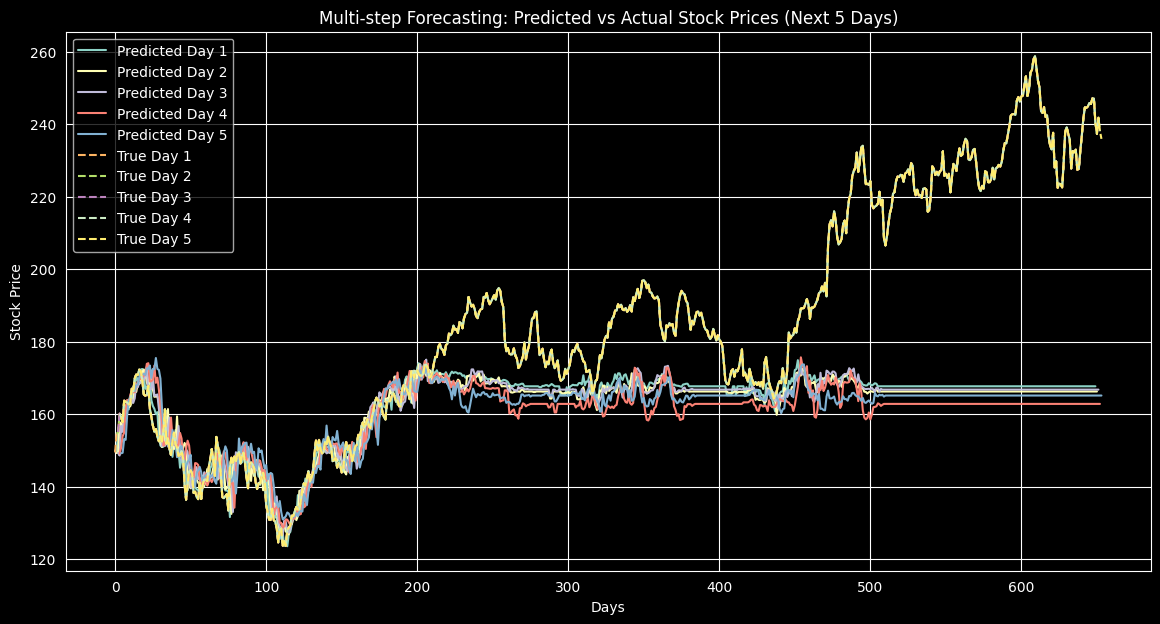

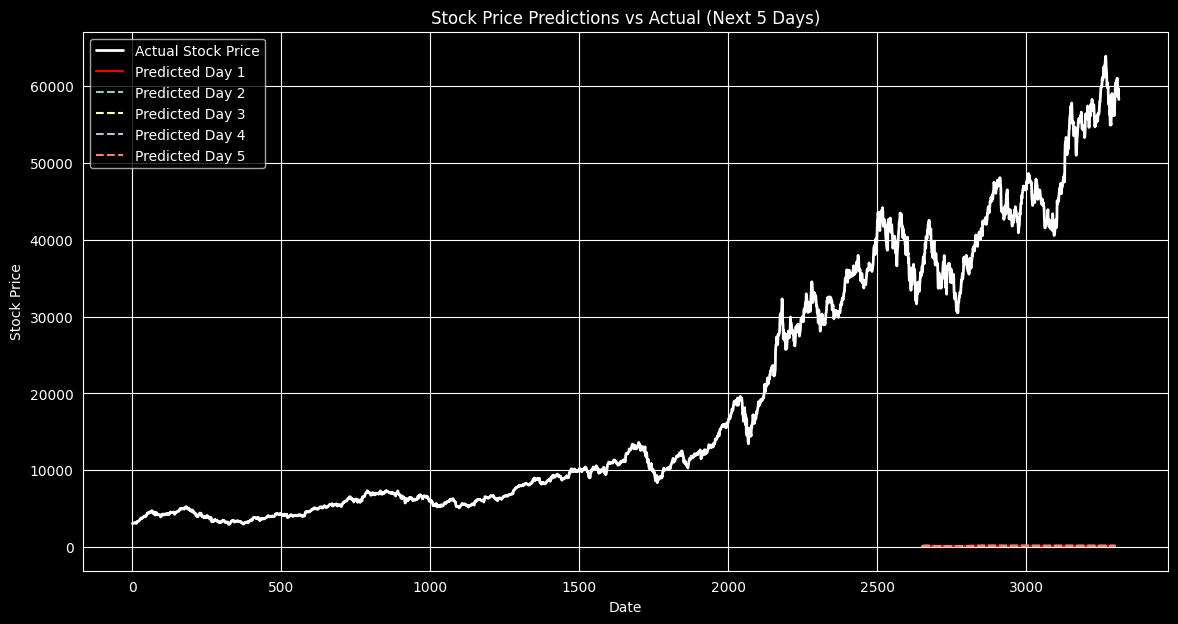

In [ ]:
# Visualization
# Plotting the predicted vs actual values for multi-step prediction
plt.figure(figsize=(14, 7))
# Plot actual values
for i in range(n_steps):
    plt.plot(range(i, len(predictions_rescaled) + i), predictions_rescaled[:, i], label=f'Predicted Day {i+1}')

# Plot true values
for i in range(n_steps):
    plt.plot(range(i, len(y_test_rescaled) + i), y_test_rescaled[:, i], linestyle='--', label=f'True Day {i+1}')

plt.title(f'Multi-step Forecasting: Predicted vs Actual Stock Prices (Next {n_steps} Days)')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(dataset), label='Actual Stock Price', color='white', linewidth=2)

# Plot predictions for the test data
predicted_dates = range(training_data_len, training_data_len + len(predictions_rescaled))
plt.plot(predicted_dates, predictions_rescaled[:, 0], label='Predicted Day 1', color='red')

for i in range(1, n_steps):
    plt.plot(predicted_dates, predictions_rescaled[:, i], label=f'Predicted Day {i+1}', linestyle='--')

plt.title(f'Stock Price Predictions vs Actual (Next {n_steps} Days)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

The chart reveals the limitations of the prediction model. It seems to struggle with capturing sudden changes in trend or volatility. It performs better in periods of stable or predictable price movements. XGBOOSt is more accurate for short-term predictions (e.g., 1 day ahead) but less accurate for longer-term predictions.

An RMSE of 0.148 suggests that, on average, the predictions are off by approximately 0.148 dollars.

# Prescriptive Analysis - LSTM-XGBoost-Q-Learning pipeline



The agent's goal is to buy at low and sell at high.


# Setting up and Loading

Import necessary libraries: It starts by importing necessary libraries such as warnings and tensorflow and suppressing some unnecessary warnings to keep the output clean.

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Data Loading: It downloads historical stock data for Apple (AAPL) using yfinance and prepares the data for machine learning.

Data Scaling: The closing prices are scaled using MinMaxScaler to a range between 0 and 1. This helps improve the performance of the machine learning models.

Data Splitting: The data is split into training and testing sets.

Loading Pre-trained Models: It loads a pre-trained LSTM model (feature_model) saved in a file named 'model.h5' and an XGBoost model saved as XGBmodel.

In [ ]:
# --- 1. Data Loading and Predictive Model Setup ---
tech_list = ['AAPL']
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)
AAPL = yf.download(tech_list, start, end)
df = AAPL

close_prices = df[('Close', 'AAPL')].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

training_data_len = int(np.ceil(len(scaled_data) * 0.70))
train_data = scaled_data[0:training_data_len, :]
lookback = 60

# Load pre-trained LSTM model for feature extraction
try:
    feature_model = keras.models.load_model('model.h5')
except OSError:
    print("Error: model.h5 not found. Please ensure the model is in the correct directory.")
    exit()


xgb_model = XGBmodel

[*********************100%***********************]  1 of 1 completed


# Creating the Trading Environment

StockTradingEnv Class: This class defines the environment for the reinforcement learning agent to interact with. It inherits from gym.Env, a standard interface for reinforcement learning environments.

__init__: Initializes the environment with stock data, models, scaler, and lookback period. It defines the action space (hold, buy, sell) and observation space (LSTM features, last action, last price).

reset: Resets the environment to its initial state, starting with a balance of 1000 and no shares held.
_next_observation: Generates the next observation (state) for the agent. It uses the LSTM model to extract features from the stock price window and combines it with the last action and price.

step: Executes an action in the environment and returns the next observation, reward, done flag, and additional information. It updates the balance, shares held, and reward based on the action taken.

In [ ]:
# --- 2. Reinforcement Learning Environment ---
class StockTradingEnv(gym.Env):
    def __init__(self, df, feature_model, xgb_model, scaler, lookback=60):
        super(StockTradingEnv, self).__init__()
        self.df = df
        self.feature_model = feature_model
        self.xgb_model = xgb_model
        self.scaler = scaler
        self.lookback = lookback
        self.action_space = spaces.Discrete(3)  # 0: Hold, 1: Buy, 2: Sell
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.feature_model.output_shape[1] + 2,),  # LSTM output + last action + last price
            dtype=np.float32
        )
        self.reset()
        self.buy_history = []  # Store buy transactions (price, quantity)
        self.sell_history = [] # Store sell transactions (price, quantity)

    def reset(self):
        self.current_step = self.lookback
        self.balance = 1000
        self.shares_held = 0
        self.action_history = []
        self.price_history = []
        return self._next_observation()

    def _next_observation(self):
        if self.current_step >= len(self.df):
            self.current_step = self.lookback

        window = self.df[('Close', 'AAPL')].values[self.current_step - self.lookback:self.current_step]
        scaled_window = self.scaler.transform(window.reshape(-1, 1))

        input_seq = scaled_window.reshape(1, self.lookback, 1)
        features = self.feature_model.predict(input_seq, verbose=0)

        last_action = self.action_history[-1] if self.action_history else 0
        last_price = self.price_history[-1] if self.price_history else self.df[('Close', 'AAPL')].values[self.lookback]

        state = np.append(features.flatten(), [last_action, last_price])
        return state

    def step(self, action):
        if self.current_step >= len(self.df):
            self.current_step = self.lookback

        current_price = self.df[('Close', 'AAPL')].values[self.current_step]
        reward = 0

        if action == 1 and self.balance >= current_price:  # Buy
            shares_to_buy = self.balance // current_price
            self.shares_held += shares_to_buy
            self.balance -= shares_to_buy * current_price
            self.buy_history.append((current_price, shares_to_buy))
        elif action == 2 and self.shares_held > 0:  # Sell
            self.balance += self.shares_held * current_price
            self.sell_history.append((current_price, self.shares_held)) # Record sell
            self.shares_held = 0


        self.current_step += 1
        done = self.current_step >= len(self.df)

        if done:
            reward = self.balance + self.shares_held * current_price - 1000

        next_obs = self._next_observation()
        self.action_history.append(action)
        self.price_history.append(current_price)
        return next_obs, reward, done, {}

# Defining the Q-Learning Agent

QLearningAgent Class: This class implements the Q-learning algorithm, a reinforcement learning technique.

__init__: Initializes the agent with hyperparameters such as learning rate (alpha), discount factor (gamma), exploration rate (epsilon), and its decay.

get_q_value: Retrieves the Q-value for a given state-action pair from the Q-table.

update_q_value: Updates the Q-value for a state-action pair based on the reward received and the estimated future rewards.

select_action: Chooses an action based on the epsilon-greedy policy. With probability epsilon, it explores random actions, and with probability 1-epsilon, it exploits the best action according to the Q-table.

decay_epsilon: Gradually reduces the exploration rate (epsilon) over time, shifting from exploration to exploitation.

In [ ]:
# --- 3. Q-Learning Agent ---
class QLearningAgent:
    def __init__(self, action_space, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01):
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = {}

    def get_q_value(self, state, action):
        if (tuple(state.tolist()), action) not in self.q_table:
            return 0
        return self.q_table[(tuple(state.tolist()), action)]

    def update_q_value(self, state, action, reward, next_state, done):
        best_next_action = max([self.get_q_value(next_state, a) for a in range(self.action_space.n)])
        target = reward + (0 if done else self.gamma * best_next_action)
        current_q_value = self.get_q_value(state, action)
        new_q_value = current_q_value + self.alpha * (target - current_q_value)
        self.q_table[(tuple(state.tolist()), action)] = new_q_value

    def select_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return self.action_space.sample()
        else:
            q_values = [self.get_q_value(state, a) for a in range(self.action_space.n)]
            return np.argmax(q_values)

    def decay_epsilon(self):
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

# Training the Agent

Environment and Agent Creation: It creates an instance of the StockTradingEnv and the QLearningAgent.

Training Loop: The agent interacts with the environment for a specified number of episodes (episodes). In each episode, the agent takes actions, receives rewards, updates its Q-table, and decays its exploration rate.

Printing Progress: It prints the total reward earned and the current exploration rate (epsilon) for each episode.

In [ ]:
# --- 4. Training the Agent ---
env = StockTradingEnv(df, feature_model, xgb_model, scaler, lookback=60) # Pass XGBoost model
agent = QLearningAgent(env.action_space)

episodes = 10
for episode in range(1, episodes + 1):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update_q_value(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    agent.decay_epsilon()
    print(f'Episode {episode}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}')

Episode 1/10, Total Reward: 88.31175231933594, Epsilon: 0.995
Episode 2/10, Total Reward: 170.88143920898438, Epsilon: 0.990025
Episode 3/10, Total Reward: 34.10487365722656, Epsilon: 0.985074875
Episode 4/10, Total Reward: 49.36846923828125, Epsilon: 0.9801495006250001
Episode 5/10, Total Reward: 49.9505615234375, Epsilon: 0.9752487531218751
Episode 6/10, Total Reward: 88.53237915039062, Epsilon: 0.9703725093562657
Episode 7/10, Total Reward: 126.47573852539062, Epsilon: 0.9655206468094844
Episode 8/10, Total Reward: 99.89816284179688, Epsilon: 0.960693043575437
Episode 9/10, Total Reward: 126.05838012695312, Epsilon: 0.9558895783575597
Episode 10/10, Total Reward: 211.31817626953125, Epsilon: 0.9511101304657719


# 5. Visual Analytics

The rest of the code focuses on visualization. It generates various plots to analyze the agent's performance, trading history, portfolio value, action distribution, exploration-exploitation trade-off, and profit over time. The code utilizes matplotlib and seaborn for creating these informative visualizations.

The visualizations in the provided code follow these best practices:

**1. Clear and Concise Titles and Labels:** Each plot has a descriptive title and clearly labeled axes, making it easy to understand the data being presented.

**2. Appropriate Chart Types:**  The code uses suitable chart types for the data:
    * **Scatter plots** effectively visualize buy/sell transactions over time.
    * **Line plots** clearly show trends in stock prices and agent performance metrics (profit over time, reward per episode, epsilon decay).
    * **Bar charts** provide a straightforward representation of the distribution of actions (hold, buy, sell).


**3. Use of Color and Markers:**  Distinct colors and markers (e.g., green triangles for buy, red triangles for sell) are used to visually differentiate between categories in scatter plots. The colors are generally well-chosen and aid in comprehension.


**4. Legends and Annotations:**  Legends are included where multiple data series are plotted on a single graph.  Annotations (text on the bars of the action distribution chart) are used to provide quantitative information.

**5. Gridlines:** Gridlines are added to most plots, making it easy to read values and identify specific data points.


**6. Figure Sizing:**  `figsize` is used to set appropriate figure sizes, making sure the plots are legible and not too cramped.

**7. Informative Comments:**  Comments are included above sections of the code, explaining the purpose of each visualization. These comments are not only useful for code readability, but also act as captions for the plots.


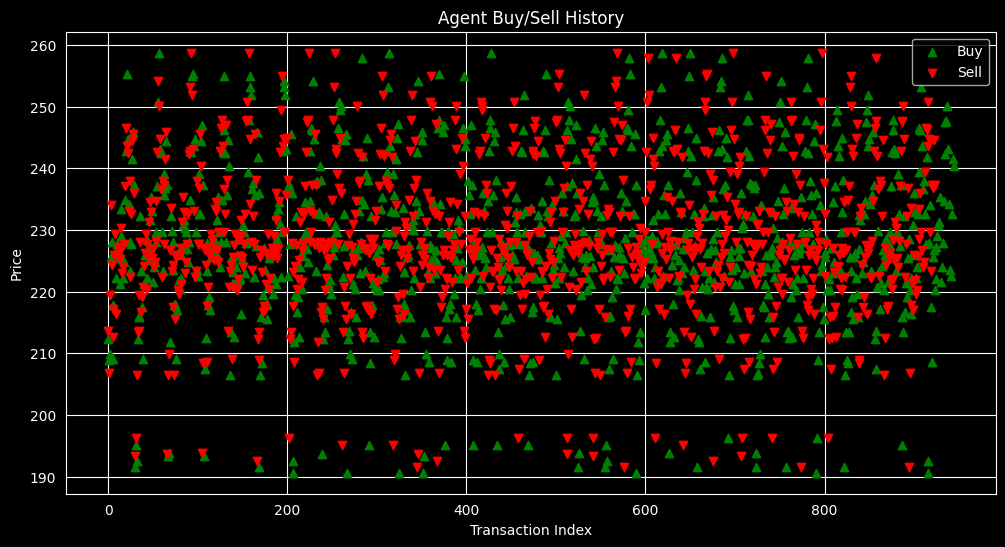

In [ ]:
# ---  Plot Buy/Sell History ---
buy_prices, buy_quantities = zip(*env.buy_history) if env.buy_history else ([], [])
sell_prices, sell_quantities = zip(*env.sell_history) if env.sell_history else ([], [])

plt.figure(figsize=(12, 6))
plt.scatter(range(len(buy_prices)), buy_prices, color='green', marker='^', label='Buy')
plt.scatter(range(len(sell_prices)), sell_prices, color='red', marker='v', label='Sell')

plt.title('Agent Buy/Sell History')
plt.xlabel('Transaction Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Agent Behavior: The chart provides insights into the trading behavior of the agent. The mixed and uniformly distributed transactions suggest an active trading strategy with frequent buy and sell decisions.

Market Activity: The high density of transactions indicates a high level of market activity.

Price Volatility: The random oscillations in price suggest potential volatility in the underlying asset being traded.

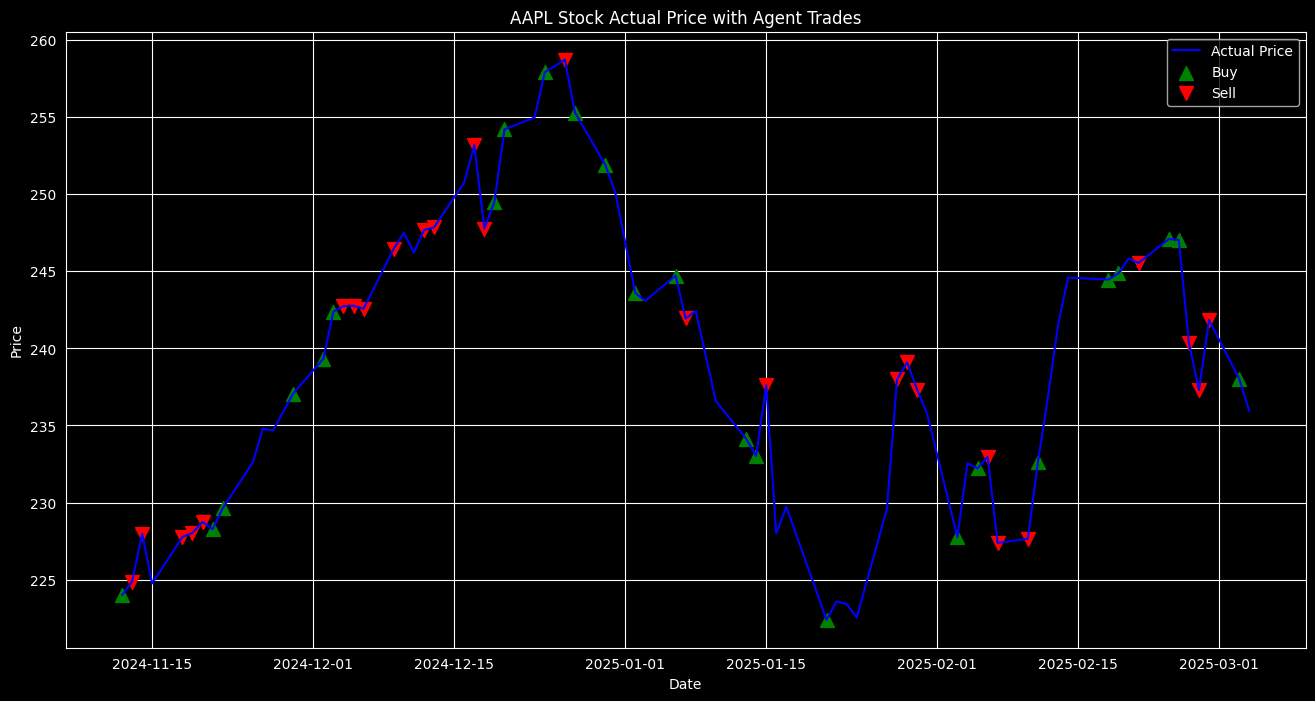

In [ ]:
# ---  Plotting Results ---
# Plotting the final results (buy/sell points, etc.)
test_data = scaled_data[training_data_len - lookback:, :]
x_test = []
y_test = close_prices[training_data_len:, :]
for i in range(lookback, len(test_data)):
    x_test.append(test_data[i - lookback:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get corresponding dates
dates = df.index[training_data_len:]

# Plot actual price and agent's trading points
plt.figure(figsize=(16, 8))
plt.plot(dates, y_test, label='Actual Price', color='blue')

# Plot buy and sell points
buy_points = [y_test[i][0] for i, action in enumerate(env.action_history) if action == 1 and i < len(y_test)]
sell_points = [y_test[i][0] for i, action in enumerate(env.action_history) if action == 2 and i < len(y_test)]
buy_dates = [dates[i] for i, action in enumerate(env.action_history) if action == 1 and i < len(y_test)]
sell_dates = [dates[i] for i, action in enumerate(env.action_history) if action == 2 and i < len(y_test)]

plt.scatter(buy_dates, buy_points, color='green', marker='^', s=100, label='Buy')
plt.scatter(sell_dates, sell_points, color='red', marker='v', s=100, label='Sell')

plt.title('AAPL Stock Actual Price with Agent Trades')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Agent Transactions:

Buy/Sell Timing: The green and red triangles indicate the timing of buy and sell transactions made by the agent.

Buy Low, Sell High? Looking closely, there are instances where the agent seems to buy when the price is relatively low and sell when the price is relatively high. For example, there are buy transactions during price dips and sell transactions near price peaks.

Frequent Trading: The agent appears to be trading frequently, with multiple buy and sell transactions throughout the period.

Reaction to Price Changes: The agent seems to react to price changes, buying during dips and selling during rises.

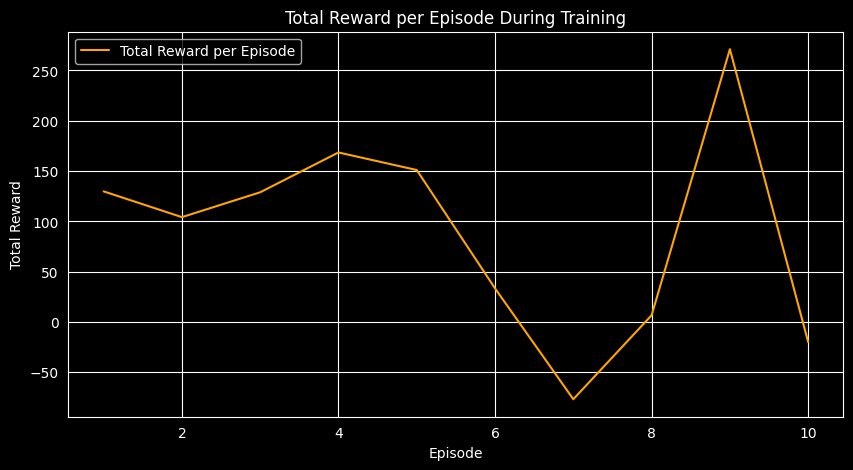

In [ ]:
# --- Plot Reward per Episode ---
# Track reward per episode to visualize the agent’s performance during training
rewards_per_episode = []
for episode in range(1, episodes + 1):
    total_reward = 0
    state = env.reset()
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
    rewards_per_episode.append(total_reward)
# Plot the total reward per episode to visualize agent performance
plt.figure(figsize=(10, 5))
plt.plot(range(1, episodes + 1), rewards_per_episode, label='Total Reward per Episode', color='orange')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode During Training')
plt.legend()
plt.grid(True)
plt.show()

Learning Progress: The chart provides insights into the agent's learning progress. The fluctuations and lack of a clear convergence trend suggest that the agent might be struggling to learn an optimal policy.

Exploration vs. Exploitation: The initial volatility could be due to the agent exploring the environment. The lack of convergence might indicate that the agent is not effectively balancing exploration and exploitation.

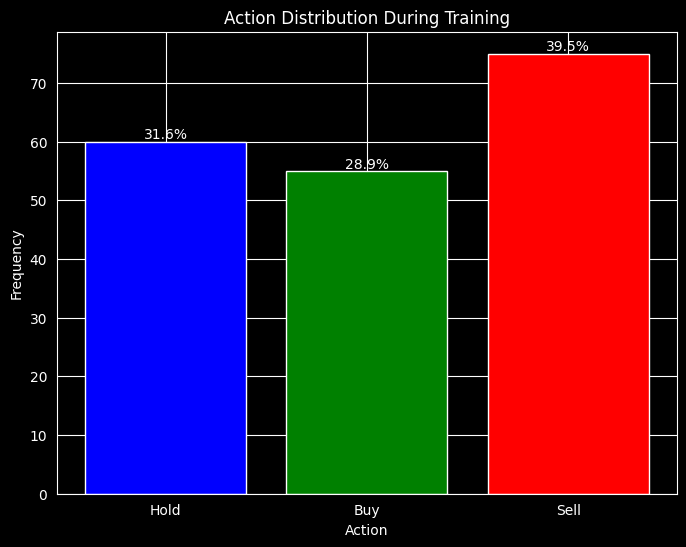

In [ ]:
# --- Plot Action Distribution ---
# Plot the distribution of actions selected by the agent
action_counts = [0, 0, 0]  # Counts for actions: [Hold, Buy, Sell]
for action in env.action_history:
    action_counts[action] += 1

total_actions = sum(action_counts)
percentages = [count / total_actions * 100 for count in action_counts]

plt.figure(figsize=(8, 6))
bars = plt.bar(['Hold', 'Buy', 'Sell'], action_counts, color=['blue', 'green', 'red'])
plt.title('Action Distribution During Training')
plt.xlabel('Action')
plt.ylabel('Frequency')

for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.1f}%', ha='center', va='bottom')

plt.show()

Agent Strategy: The chart provides insights into the agent's trading strategy. The high frequency of "Hold" actions suggests a conservative approach, where the agent prefers to maintain its position unless there is a strong reason to buy or sell.

Balanced Trading: The balanced distribution of "Buy" and "Sell" actions suggests that the agent is not biased towards either buying or selling. This could indicate that the agent is adapting to market fluctuations and taking both long and short positions.

Exploration vs. Exploitation: The high frequency of "Hold" actions might indicate that the agent has learned to exploit certain situations where holding the position is optimal. However, the presence of "Buy" and "Sell" actions suggests that the agent is still exploring the environment and trying to find profitable trading opportunities.

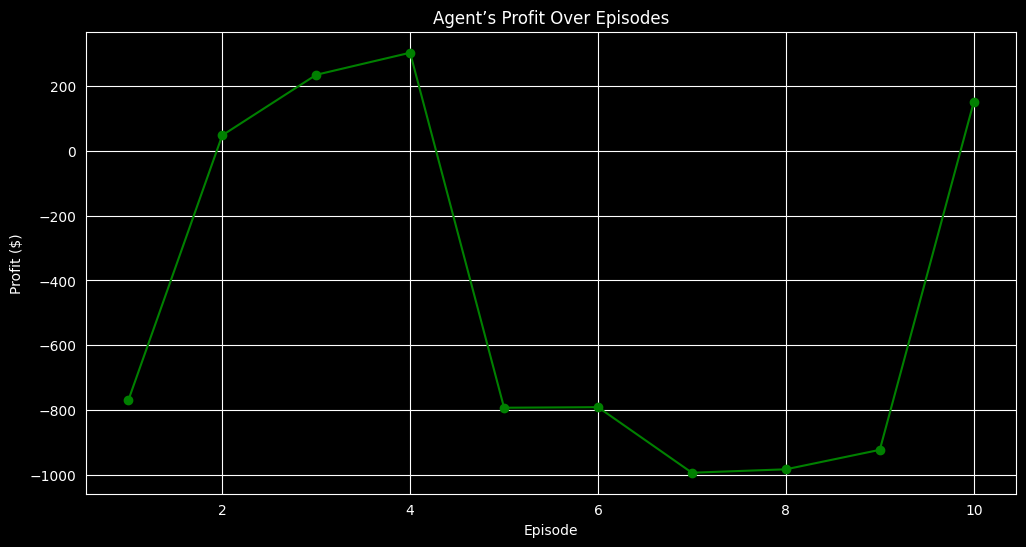

In [ ]:
# Agent's Profit Over Episodes
profits = []
balance_history = []
for episode in range(1, episodes + 1):
    state = env.reset()
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
    profits.append(env.balance - 1000)  # Profit at the end of each episode
    balance_history.append(env.balance)

plt.figure(figsize=(12, 6))
plt.plot(range(1, episodes + 1), profits, marker='o', linestyle='-', color='green')
plt.xlabel('Episode')
plt.ylabel('Profit ($)')
plt.title('Agent’s Profit Over Episodes')
plt.grid(True)
plt.show()


Agent Performance: The chart provides a clear picture of the agent's performance in terms of profit. The high volatility and dominance of negative profits suggest that the agent's strategy is not consistently profitable.

Risk Management: The large losses indicate that the agent might not be effectively managing risk.

Learning Challenges: The lack of a clear trend suggests that the agent might be struggling to learn an optimal strategy or adapt to the environment.

Exploration vs. Exploitation: The fluctuations could be due to the agent exploring different strategies or encountering varying market conditions.

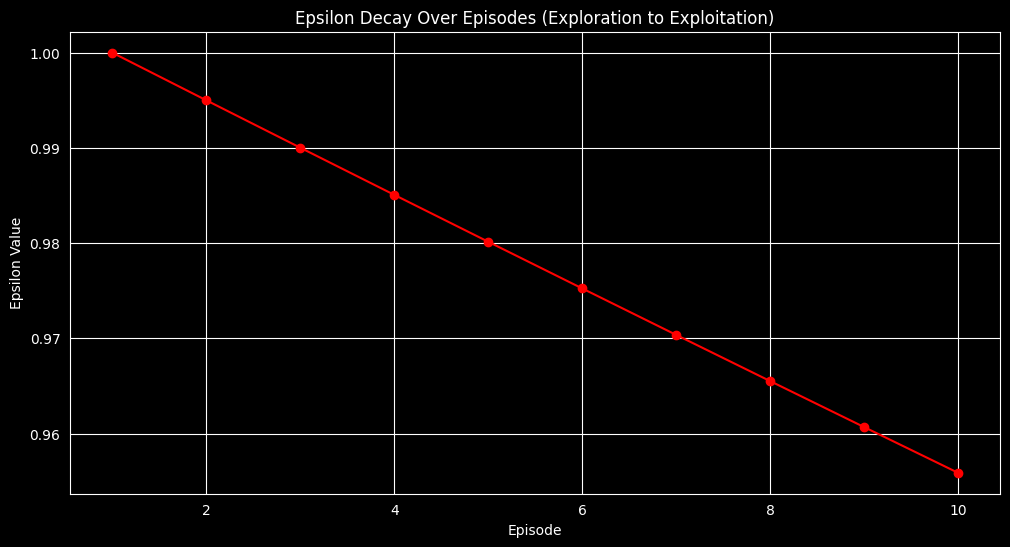

In [ ]:
# Exploration vs. Exploitation (Epsilon Decay)
epsilon_values = [1.0 * (agent.epsilon_decay ** i) for i in range(episodes)]

plt.figure(figsize=(12, 6))
plt.plot(range(1, episodes + 1), epsilon_values, marker='o', linestyle='-', color='red')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay Over Episodes (Exploration to Exploitation)')
plt.show()


Exploration-Exploitation Tradeoff: The chart demonstrates the gradual shift from exploration to exploitation, which is a fundamental concept in reinforcement learning.

Learning Strategy: The linear decay suggests a specific learning strategy where the agent prioritizes exploration in the early stages and gradually transitions to exploitation as it learns more about the environment.

High Exploration at the End: The relatively high exploration rate at the end of training might indicate that the environment is complex or that the agent needs to continue exploring to find optimal solutions.